<a href="https://colab.research.google.com/github/KnowledgeLab/Thinking-With-Deep-Learning-2025/blob/main/Tutorials-Homework_Notebooks/Week%204/tutorial_1_deep_learning_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thinking with Deep Learning: Week 4 Part 1
# Deep Learning for Text

__Instructor:__ James Evans

__Teaching Assistants & Content Creators/Organisers:__ Shiyang Lai & Avi

In this notebook we will be walking through some basic methods for text exploration before we dive into deeper textual analysis using neural word embeddings.

NOTE: We acknowledge that this is another notebook with a lot of code - but do not fear, it is only here to help you. You don't need to run all of it, and in many cases we pursue multiple ways to perform an activity, such as a word or sentence embedding. Think of all of the code as a resource to help you do the HW and your group projects.

NOTE: As usual, we recommend looking at the HW first before going through and running each of the cells, as some of it may not be relevant to what you seek to accomplish. This notebook is expected to be a resource on the different kinds of static neural based methods for text, which can be quickly adapted for your analysis of choice. You are not expected to master all of these methods, but to be aware of them. The homework will require you to use a variety of them to come up with a meaningful exploration and analysis of your textual data.

#### imports and installations

In [1]:
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-58q_7nc6
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-58q_7nc6
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -U yellowbrick

In [3]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


In [4]:
import lucem_illud

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# text related packages
import gensim
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# ML and DL packages
import sklearn
import keras

Let's also load the spacy English Language model, which we draw upon.

In [6]:
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [7]:
# generally not good practice, as we want to see warnings - but in this case, there are no critical warnings
import warnings
warnings.filterwarnings('ignore')

## Cleaning, Organising, and Representing Text Data

This section will cover basic code and key concepts for textual data cleaning, organising and representing. We often describe this part of dealing with data as pre-processing. We also note that it is often encouraged to perform less pre-processing with deep learning methods and more data (e.g., stem with small data and non-neural methods; do not stem with big data and neural methods.) At the limits, with extremely large data and very deep models, we may actually add noise to the data to increase the robustness of our models to errors and outliers.

Let's whip up some trivial texts so that we can illustrate the creation of different representations. We will construct our raw texts such that there are a few overlapping words. Note that there are 4 sentences, and each sentence is the complete document or text.

In [8]:
raw_texts = ["Apples taste like onions when we cannot smell.",
             "I find it easy to compare apples and oranges.",
             "Chopping onions can make you cry.",
             "Peeling an orange does not make you cry."]

We now load an English [spaCy language model](https://spacy.io/usage/models), which allows us to do a number of basic linguistic and textual analysis.

In [9]:
nlp = spacy.load('en_core_web_sm')

Our first use of the language model is to clean the data - when we pass text through the language model, it [tokenises](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) it, and assigns various attributes, such as whether or not it is a [stop word](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), number, and its part of speech. A stop word is a word we deem irrelevant or will distract from or diminish our analysis - some examples are articles (a, an, the), filler words, and so on. You will notice that here we also used a [lemmatised](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) form of the word, which is a way of extracting the linguistic 'root' of the word. Again, the more plentiful your data and deeper your model (e.g., BERT), the less likely you should be to remove, prune and process text data because the model is designed to do it for you. Even then, however, sometimes augmenting data with these representations can accelerate model training and performance.

In [10]:
texts, article = [], []
for text in raw_texts:
    doc = nlp(text)
    article = []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.lemma_)

    texts.append(article)

Let's see what that did to our texts.

In [11]:
texts

[['apple', 'taste', 'like', 'onion', 'smell'],
 ['find', 'easy', 'compare', 'apple', 'orange'],
 ['chop', 'onion', 'cry'],
 ['peel', 'orange', 'cry']]

We see that from a list of strings we now have a list of lists, and each of these lists is a list of strings (words, or tokens). You can see that punctuation and stop words are removed and it is now closer to machine-readable and analysis-ready. This process of going from raw, punctuated text to individual tokens is called tokenization.

Now, we use the gensim dictionary class to map each of these words to an ID and represent them as a bag of words.

In [12]:
dictionary = Dictionary(texts)

In [13]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [14]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(0, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(2, 1), (9, 1), (10, 1)],
 [(8, 1), (10, 1), (11, 1)]]

We see here that each sentence is represented by a word ID and the number of times it was present in that document. We now look at Term Frequency - Inverse Document Frequency ([TF-IDF](https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)), one simple way to measure word importance (locally and globally). Such representations begin to build representations that begin to approximate some of the things automatically learned within a deep model. Sometimes these representations can be fed into a deep model as input (augmented data).

In [15]:
from gensim.models import TfidfModel

In [16]:
tf_idf_model = TfidfModel(corpus)

In [17]:
tf_idf_texts = tf_idf_model[corpus]

In [18]:
tf_idf_texts[0]

[(0, 0.2672612419124244),
 (1, 0.5345224838248488),
 (2, 0.2672612419124244),
 (3, 0.5345224838248488),
 (4, 0.5345224838248488)]

In [19]:
tf_idf_texts[1]

[(0, 0.2672612419124244),
 (5, 0.5345224838248488),
 (6, 0.5345224838248488),
 (7, 0.5345224838248488),
 (8, 0.2672612419124244)]

We now see each document is a word ID mapped to a number that measures how it distinguishes the document.

### One Hot Encoding and Vectorising with scikit-learn

So we saw how we can go from raw, punctuated texts to cleaner texts my manually picking out what we want. The bag of words format tells us which words exist, but the vector length isn't standard, and you can see the same for TF-IDF. There are ways to present this information in what is called a 1-hot vector, where the length of the vector is the whole vocabulary.

It can be useful to use gensim and spaCy for pre-processing because it is more clear at each step what my data structure looks like. However, for an abstracted approach to text pre-processing, scikit-learn works well, especially when you want to feed it into a traditional machine learning algorithm. Gensim, for example, would convert bag of words or tf-idf into a similar data structure under the hood to keep the lengths of the vector the same.

See below for code to use the scikit-learn vectoriser, which creates both one hot encoding vectors as well as tf-idf vectors which are **sparse representations**.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

In [21]:
vectorizer = CountVectorizer()

In [22]:
X = vectorizer.fit_transform(raw_texts).toarray()

In [23]:
vectorizer.vocabulary_

{'apples': 2,
 'taste': 20,
 'like': 12,
 'onions': 15,
 'when': 23,
 'we': 22,
 'cannot': 4,
 'smell': 19,
 'find': 10,
 'it': 11,
 'easy': 9,
 'to': 21,
 'compare': 6,
 'and': 1,
 'oranges': 17,
 'chopping': 5,
 'can': 3,
 'make': 13,
 'you': 24,
 'cry': 7,
 'peeling': 18,
 'an': 0,
 'orange': 16,
 'does': 8,
 'not': 14}

In [24]:
raw_texts

['Apples taste like onions when we cannot smell.',
 'I find it easy to compare apples and oranges.',
 'Chopping onions can make you cry.',
 'Peeling an orange does not make you cry.']

In [25]:
len(X[0]), len(vectorizer.vocabulary_)

(25, 25)

You can see that the length of each vector is the length of the full vocavulary. Below, for each document, a 1 is a presence of that word_id (which you can confirm using the dictionary above), and a 0 is the absence of a word.

In [26]:
print(X)

[[0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0]
 [0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1]]


Below this we create a similar sparse representation, but using TF-IDF, and remove stop-words using the built-in function.

In [27]:
vectorizer = TfidfVectorizer(stop_words='english')

In [28]:
X = vectorizer.fit_transform(raw_texts).toarray()

In [29]:
print(X)

[[0.38274272 0.         0.         0.         0.         0.48546061
  0.         0.38274272 0.         0.         0.         0.48546061
  0.48546061]
 [0.41428875 0.         0.52547275 0.         0.52547275 0.
  0.         0.         0.         0.52547275 0.         0.
  0.        ]
 [0.         0.66767854 0.         0.         0.         0.
  0.52640543 0.52640543 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.52547275 0.         0.
  0.41428875 0.         0.52547275 0.         0.52547275 0.
  0.        ]]


We will now be moving on from sparse representations to dense representations of documents, with a range of methods which can be used to condense information in a body of text.

### Low and High Dimensional Representations of Text and Documents

One of the issues with using a bag of words or TF-IDF to represent documents is that even though you’ve reduced the size of the document from the full vocabulary, for documents with a lot of words, they remain very high dimensional objects (e.g., where each dimension is defined by a word in the vocabulary, a long document might have 20,000 dimensions or unique words). LSA stands for latent semantic analysis (sometimes also referred to as LSI, or Latent Semantic Indexing), and is a way to represent text documents by reducing the dimensionality of the word (or meaning)-space represented by a TF-IDF or bag of words. The idea is this: if words in documents are rows and the documents are columns, we want to keep the same distance between columns (documents) while reducing the number of rows (reduced word-features). By representing documents with a reduced number of features instead of using all the words, we now represent each with “latent” features rooted in the idea of distributional semantics--that words appearing together are likely to reference similar meanings.

Let us use TruncatedSVD to perform a latent semantic analysis on our data. SVD -- Singular Value Decomposition -- is a form of matrix factorization very similar to Principle Components Analysis (PCA), which we saw last week, but it can be computed on rectangular (not square) datasets. The truncation comes as we limit the number of Singular Values (dimensions) that we consider by selecting the most informative and distinguishing $n$.

In [30]:
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [31]:
X = lsa.fit_transform(X)

In [32]:
X

array([[ 0.80128627,  0.59828114],
       [ 0.41506543,  0.90979156],
       [ 0.93368336, -0.35809968],
       [ 0.66405657, -0.74768233]])

Each document here is represented by 2 features ($n=2$)!

Now we'll take a quick peak at topic models, word and document embedding methods, and other low dimensional methods that can be used to represent document in meaning space.

We're going to use a bigger dataset, because these methods are only useful when we have substantial data. Models based on very large datasets take time to train, so we'll use a medium sized corpus that comes pre-loaded with gensim to illustare the concepts.

In [33]:
import os

In [34]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

In [35]:
doc = nlp(text.lower())

In [36]:
my_stop_words = [u'say', u'mr', u'said', u'saying', u'says']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [37]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text != 'I':
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [38]:
len(texts)

299

In [39]:
texts[0][0:10]

['hundred',
 'people',
 'force',
 'vacate',
 'home',
 'southern',
 'highland',
 'new',
 'south',
 'wale']

### Bi-grams and n-grams
Here we identify statistically significant bigrams (two sequential word units of meaning) that may go into a model as single units.

In [40]:
bigram = gensim.models.Phrases(texts)

In [41]:
texts = [bigram[line] for line in texts]

In [42]:
texts[0][0:20]

['hundred',
 'people',
 'force',
 'vacate',
 'home',
 'southern',
 'highland',
 'new_south',
 'wale',
 'strong',
 'wind',
 'today',
 'push',
 'huge',
 'bushfire',
 'town',
 'hill',
 'new',
 'blaze',
 'near']

# Precursors and Diagnostics for Deep Neural Networks

Before diving into using deep neural models for text, it is useful to have an idea what your textual data looks like. This process of exploratory data analysis (EDA) can be done in many ways - we will explore some of the more popular approaches, some of which you've seen in our earlier notebook on representations of text data.

NOTE: usually, we are running deep neural methods on very large bodies of text. Some of the methods we will be exploring in this section are optimized for small to medium bodies of text; we recommend you sample from your very large datasets and explore these methods.

### Data

First, we being loading a sample corpus to play with. It is useful for us to demonstrate these examples with a dataset with text from a similar theme, but different topics, so that we have some differentiation. We will be using the hobbies dataset which comes pre-loaded with [YellowBrick](https://www.scikit-yb.org/en/latest/index.html), a python Machine Learning visualisation toolkit.

The hobbies corpus is a text corpus wrangled from the [Baleen RSS Corpus](https://github.com/DistrictDataLabs/baleen) to enable students and readers to practice different techniques in Natural Language Processing. It is structured as:

Overall:

- 7,420 paragraphs (16.562 mean paragraphs per file)

- 14,251 sentences (1.921 mean sentences per paragraph).

By Category:

- books: 72 docs, 844 paragraphs and 2,030 sentences

- cinema: 100 docs, 1,475 paragraphs and 3,047 sentences

- cooking: 30 docs, 1,190 paragraphs and 2,425 sentences

- gaming: 128 docs, 1,802 paragraphs and 3,373 sentences

- sports: 118 docs, 2,109 paragraphs and 3,376 sentences


In [43]:
from yellowbrick.datasets import load_hobbies

In [44]:
corpus = load_hobbies()

In [45]:
len(corpus.data)

448

In [46]:
corpus.data[0]

'\nBrunch is one of my favorite meals, but it often involves a lot of last minute preparation if you are the one hosting it. Eggs, salads and baked goods all need to be prepared either just before people arrive, or just before you sit down to eat. You can help the eggs along by making a breakfast casserole, but you can save even more time by preparing this fantastic Overnight Coffee Cake. The coffee cake – and you can get the recipe over on the Craftsy blog (it’s free!) – and the streusel are both prepared the night before you intend to bake and the assembled cake is refrigerated until it is ready to go in the oven. The resulting cake has a soft, even crumb and just the right amount of crunchy streusel topping. Your guests will never know how much time you saved (or that you got to sleep in for an extra hour!) by serving up this amazing cake.\n\nIf you prefer nuts in your coffee cake, you can stir in about a 1/2 cup or so of finely chopped nuts while preparing the batter. The same goes

In [47]:
corpus.target[0]

'cooking'

In [48]:
corpus.data[200]

"\n\nWhile not as popular as in the 90s, Sailor Moon still has a fan base, at least judging from cosplayers and Sailor Moon merchandise. If you do enjoy Sailor Moon and her quirky sidekicks, you'll be glad to know that after a few months in Japan, SailorMoon Drops\xa0[Free] has come to the US App Store. As for the gameplay, I'll give you exactly one guess to figure out how this game plays. Yes, a match-3 indeed. All of the characters have been transformed into cute versions of themselves, and the game does contain a storyline that you'll play through as you solve those match-3 puzzles. The game includes many familiar characters (both friends and enemies), and is definitely very cute to look at.\n\nVIDEO\n\n\nAs you clear stages, you level up your characters and unlock special moves (and also cute poses), and even gather various collection pieces to unlock wallpapers. You can play with or against your friends, and you can play either in portrait or landscape, a small thing for some but 

In [49]:
corpus.target[200]

'gaming'


## Principal Component Analysis and Latent Semantic Analysis

Latent Semantic Analysis or Indexing (LSA / LSI) (Landauer et al. 2013) is a “a high-dimensional linear associative model that embodies no human knowledge beyond its general learning mechanism, to analyze a large corpus of natural text and generate a representation that captures the similarity of words and text passages”. That’s from the original paper and suggests what LSA is - a way to computationally represent groups of words as belonging in a certain location of a high dimensional space in relation to other semantically related groups of words.

It does this through a process called Singular Value Decomposition, a general method for the linear decomposition of a matrix into independent singular values. Intuitively, it does this by rotating the high dimensional space, scaling it, and rotating it again. This process allows us to represent a dataset from different orientation, after which we can choose the $n$ most important of these dimensions. In Latent Semantic Analysis, the matrix which we are decomposing is the document-term matrix - the matrix of which words appear in which documents, a representation we have seen before in section 2.1.1. If the entire vocabulary size is, say, 100,000, and we decide to represent our documents with only 300 features, then SVD helps us go from the very high dimensional vocabulary-sized space our documents sit within to one more manageable.

This is conceptually close to what neural networks do. In fact, in the original LSA paper, they have a section titled ‘A Neural net Analog of LSA’!

In the code below we use scikit-learn to first vectorise the text and remove stop words, and then reduce it to a 5 dimensional space.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [51]:
vectorizer = TfidfVectorizer(stop_words='english')

In [52]:
tfidf_texts = vectorizer.fit_transform(corpus.data).toarray()

In [53]:
# vectorizer.vocabulary_

Let's remind ourselves what that does to the data. We create a very sparse, high dimensional vector where each word is mapped to its TF-IDF score, and the length of each vector is the total vocabulary.

In [54]:
len(tfidf_texts[0])

19849

In [55]:
tfidf_texts[0][0:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [57]:
lsa_texts = lsa.fit_transform(tfidf_texts)

In [58]:
lsa_texts[0]

array([ 0.40908784, -0.18295056, -0.27474281, -0.63843731, -0.56221919])

That representation of text is now reduced from 19849 to 5 dimensions.

While LSA is specifically for textual documents in setup, PCA is an older, general purpose algorithm to reduce the dimensionality of a dataset. Modern implementations of PCA and LSA have SVD in common - while for LSA we perform the linear decomposition on the document term matrix, for PCA the dimensionality reduction is done on the covariance matrix of the dataset, and in this process it reduces it into features that retain the most variance (and thus have the highest explanatory power). When we apply such a method to a textual dataset, we reduce our representation of the textual dataset into a lower dimensional space where we can better understand large scale patterns. Note that we can run PCA on any kind of representation of text - a bag of words matrix, a TF-IDF representation, or even on a representation such as LSA (SVD) or word2vec, given that the LSA or word2vec has a high enough dimensionality so that PCA is useful.


In [59]:
from sklearn.decomposition import PCA


In [60]:
pca = PCA(n_components=5)

In [61]:
pca_texts = pca.fit_transform(tfidf_texts)

We're going to see how much each of these 5 dimensions explain in the total data. The explained variance ratio is the percentage of variance attributable to each of the selected components.

In [62]:
pca.explained_variance_

array([0.00794639, 0.00733747, 0.00697602, 0.00611795, 0.00557666])

Not much, but a PCA isn't always suited for text data. Let's see what each document looks like.

In [63]:
pca_texts[0]

array([-0.02514312,  0.06559218, -0.01792559, -0.18144187, -0.0295236 ])

We've similarly reduced our representation to 5 dimensions.

These representations can then be used for other machine learning tasks, and for visualisation (which we will see later).

## Random Projection

Another method to index documents. [Random Indexing of Text Samples for Latent Semantic Analysis](https://escholarship.org/content/qt5644k0w6/qt5644k0w6.pdf)

In [64]:
from gensim.models import RpModel
from gensim.corpora import Dictionary
from gensim.test.utils import common_texts

dictionary = Dictionary(common_texts)  # fit dictionary
corpus_2 = [dictionary.doc2bow(text) for text in common_texts]  # convert texts to BoW format

model = RpModel(corpus_2, id2word=dictionary)  # fit model

In [65]:
rpmtexts = model[corpus_2]

This converts our documents into a 300 dimensional *random projection* which can also be used to represent our documents.

In [66]:
rpmtexts[0]

[(0, -0.17320506274700165),
 (1, 0.17320506274700165),
 (2, -0.17320506274700165),
 (3, -0.17320506274700165),
 (4, -0.05773502215743065),
 (5, 0.05773502215743065),
 (6, 0.05773502215743065),
 (7, -0.05773502215743065),
 (8, -0.05773502215743065),
 (9, -0.17320506274700165),
 (10, -0.05773502215743065),
 (11, 0.05773502215743065),
 (12, -0.17320506274700165),
 (13, -0.05773502215743065),
 (14, 0.17320506274700165),
 (15, -0.05773502215743065),
 (16, -0.05773502215743065),
 (17, -0.05773502215743065),
 (18, 0.17320506274700165),
 (19, 0.17320506274700165),
 (20, -0.05773502215743065),
 (21, -0.17320506274700165),
 (22, 0.05773502215743065),
 (23, 0.05773502215743065),
 (24, 0.05773502215743065),
 (25, 0.05773502215743065),
 (26, -0.05773502215743065),
 (27, -0.05773502215743065),
 (28, 0.17320506274700165),
 (29, -0.17320506274700165),
 (30, -0.17320506274700165),
 (31, -0.05773502215743065),
 (32, -0.05773502215743065),
 (33, -0.05773502215743065),
 (34, -0.05773502215743065),
 (35, 0

## Probabilistic Topic Models

NOTE: this section covers topic models which are not necessary to know in detail for neural methods. You may skip this section if focusing on only neural methods, but topic models are often used in social scientific exploratory data analysis and this could serve as a useful resource for understanding a modest corpus of data. (They do not perform well on massive corpora where neural methods are superior; but they are often superior to neural methods for encoding smaller text.)

Topic modelling algorithms are built with the intuition that documents exhibit multiple latent "topics". When we phrase this relationship by suggesting that the documents are generated by a probabilistic process that assigns certain words to certain topics, we can build a framework to identify what these underlying topics might be that generate the documents. Each round of training here on a corpus involves a process where the model converges on a representation of words in topics where the topics are most likely to have generated the documents in the corpus. Different topic modelling algorithms have different approaches to how they create the distribution of words in topics and documents in topics.


### Latent Dirichlet Allocation

One of the earliest topic modelling algorithms is Latent Dirichlet Allocation, which is a generative process where in each step of the algorithm, for each document, it starts by randomly generating a distribution of words over the topics, using a Dirichlet distribution.
Subsequent steps involve assigning words to the document from the topic-word distribution in an attempt to recreate observed variables, which are documents. Here we have topics, documents and words related in a joint distribution. In this iterative process of finding an optimal distribution of latent variables (topics) to generate the documents, we attempt to estimate the posterior distribution. This simply means identifying the distribution of topics most likely to have generated the documents we see. Generative models such as LDA belong to the class of algorithms called probabilistic graphical models, because they can also be described as a graph where each node is a random variable.

This is another method we explored before, albeit briefly. We will revisit it, and also explore other topic modelling methods.

In [67]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

In [68]:
from gensim.parsing.preprocessing import preprocess_documents

In [69]:
preprocessed_texts = preprocess_documents(corpus.data)

In [70]:
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

In [71]:
ldamodel = LdaModel(corpus=corpus, num_topics=2, id2word=dictionary)

In [72]:
ldamodel.print_topics()

[(0,
  '0.006*"game" + 0.005*"time" + 0.005*"year" + 0.004*"new" + 0.004*"like" + 0.004*"work" + 0.003*"film" + 0.003*"season" + 0.003*"plai" + 0.003*"want"'),
 (1,
  '0.009*"game" + 0.006*"like" + 0.004*"new" + 0.004*"year" + 0.004*"plai" + 0.004*"time" + 0.003*"team" + 0.003*"work" + 0.003*"look" + 0.003*"wai"')]

Not too useful. Without any fine tuning, results from this topic modelling aren't terribly useful. The corpus isn't large enough or doesn't seem to be differentiated enough for us to see individual hobbies emerge.

Topic modelling usually involves multiple rounds of cleaning and parameter tuning for it to be useful on smaller datasets. For the cleaning process, we used the builtin pre-processing with gensim which has stemmed the words. Cleaning processes can have very dramatic effects on the results of your topic model. In the homework, you will be given an option to further explore and tune topic models for bonus points.

We link you to some useful resources for tuning gensim topic models:

- [Gensim LDA: Tips and Tricks](https://miningthedetails.com/blog/python/lda/GensimLDA/)
- [Gensim LDA documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py)
- [Pre-processing and training LDA](https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html)

#### Topic Coherence

Topic coherence is one numerical method often used to evaluate between topic models. The following links will guide you to using topic coherence with gensim.

- [Topic Coherence Tutorial](https://markroxor.github.io/gensim/static/notebooks/topic_coherence_tutorial.html)
- [Gensim topic coherence documentation](https://radimrehurek.com/gensim/models/coherencemodel.html)
- [Comparing between multiple topic models](https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html)

### Heirarchial Dirichlet Process

The next topic model we will use is the Hierarchical Dirichlet Process, which uses similar methods used in LDA to identify the distribution of topics in a corpus, but is more flexible because it infers the number of topics from the corpus.

In [73]:
from gensim.models import HdpModel


In [74]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [75]:
hdpmodel.print_topics()

[(0,
  '0.005*game + 0.004*like + 0.004*time + 0.004*plai + 0.003*year + 0.003*book + 0.003*point + 0.003*said + 0.003*team + 0.003*know'),
 (1,
  '0.006*game + 0.005*june + 0.005*team + 0.005*year + 0.004*new + 0.004*april + 0.004*season + 0.004*like + 0.004*plai + 0.003*time'),
 (2,
  '0.004*januari + 0.004*like + 0.004*year + 0.004*spaghetti + 0.003*pasta + 0.003*recip + 0.003*thank + 0.003*time + 0.003*i’m + 0.003*pan'),
 (3,
  '0.004*like + 0.004*game + 0.003*year + 0.003*blazer + 0.003*season + 0.003*portland + 0.003*olshei + 0.003*trail + 0.002*time + 0.002*stori'),
 (4,
  '0.005*game + 0.003*said + 0.003*team + 0.003*nba + 0.003*new + 0.002*plai + 0.002*year + 0.002*season + 0.002*time + 0.002*final'),
 (5,
  '0.004*content + 0.003*wai + 0.002*peopl + 0.002*game + 0.002*develop + 0.002*like + 0.002*product + 0.002*year + 0.002*work + 0.002*said'),
 (6,
  '0.002*film + 0.002*work + 0.002*like + 0.001*project + 0.001*bacevich + 0.001*mind + 0.001*exercis + 0.001*come + 0.001*amer

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [76]:
hdptexts = hdpmodel[corpus]

In [77]:
hdptexts[0]

[(2, 0.5254045025853282), (40, 0.4635046242363301)]

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

### Dynamic Topic Models

We have seen how often we come across time stamped data. Topic models adapt to this scenario as well, and the dynamic topic model can be used to see how topics evolve over time. Dynamic topic models work by building a ‘static’ topic model for the first time slice and then changing the distribution of words for each time slice, allowing us to see an evolution.

In the interest of time, we link to a popular existing [dynamic topic model tutorial](https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html) using gensim.

In the homework, you will have an option to implement dynamic topic models for bonus points.

In [78]:
# empty cell

### Concluding topic models

In our attempts to model very large collections of textual documents, we may find that diving in without any idea of what the dataset looks like might be counter-productive. By sampling a portion of the dataset and constructing topic models, we begin to have an idea of the kinds of key topics and words - words which are in the same topic are probably likely to appear in a similar part of a semantic space created by a neural model, and we can use topic models to sanity check our results. Similarly, when attempting to capture how word embeddings might change over time, running a dynamic topic model over the same corpus might offer us insights to guide our intuitions.

## Clustering Words and Documents

A useful to visualise your word or document space is by clustering documents. The link below will walk you through how to cluster your documents - you are of course free to use whatever resource you want.

[Tutorial on document clustering](http://brandonrose.org/clustering)

In [79]:
# empty cell

## Visualizing documents and words in space

In this section we will look at some methods to visualise documents.


### Frequency Plot and Lexical Dispersion

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

In [81]:
corpus = load_hobbies()

In [82]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(corpus.data)
features   = vectorizer.get_feature_names_out()

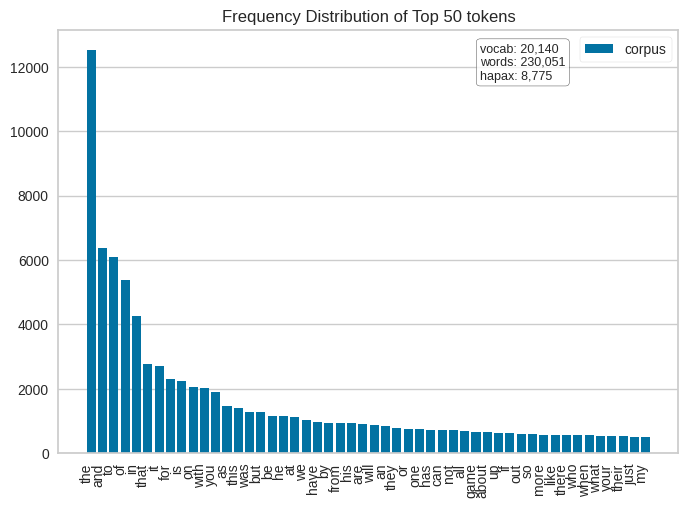

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [83]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

We see most of these words are stop words and don't provide us with any useful information. Let's get those out of the way and see what our corpus looks like.

In [84]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(corpus.data)
features   = vectorizer.get_feature_names_out()

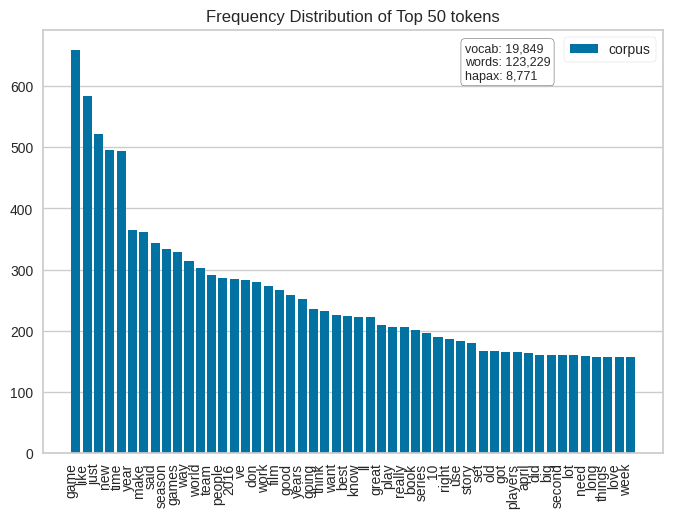

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [85]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

This quickly gives us an overview of the kinds of words being used - does this help explain why the topic models gave us the results it did?

### Projecting PCA and LSA

We earlier saw our PCA and LSA created representations of our text - let's visualise these in lower dimensions to see if they capture useful structural information!

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap

In [87]:
def plot_vectors(vectors, labels):
    # Set up the 3D plot
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')  # Use add_subplot with projection='3d'

    # Get colors
    cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

    # Plot the first three dimensions
    sc = ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2],
                    c=labels, marker='o', alpha=1, cmap=cmap)

    # Label the axes
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')

    # Add a color bar
    plt.colorbar(sc)
    plt.show()

In [88]:
labels = corpus.target

In [89]:
from sklearn import preprocessing


In [90]:
le = preprocessing.LabelEncoder()

In [91]:
le.fit(labels)

LabelEncoder()

In [92]:
labels = le.transform(labels)

In [93]:
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

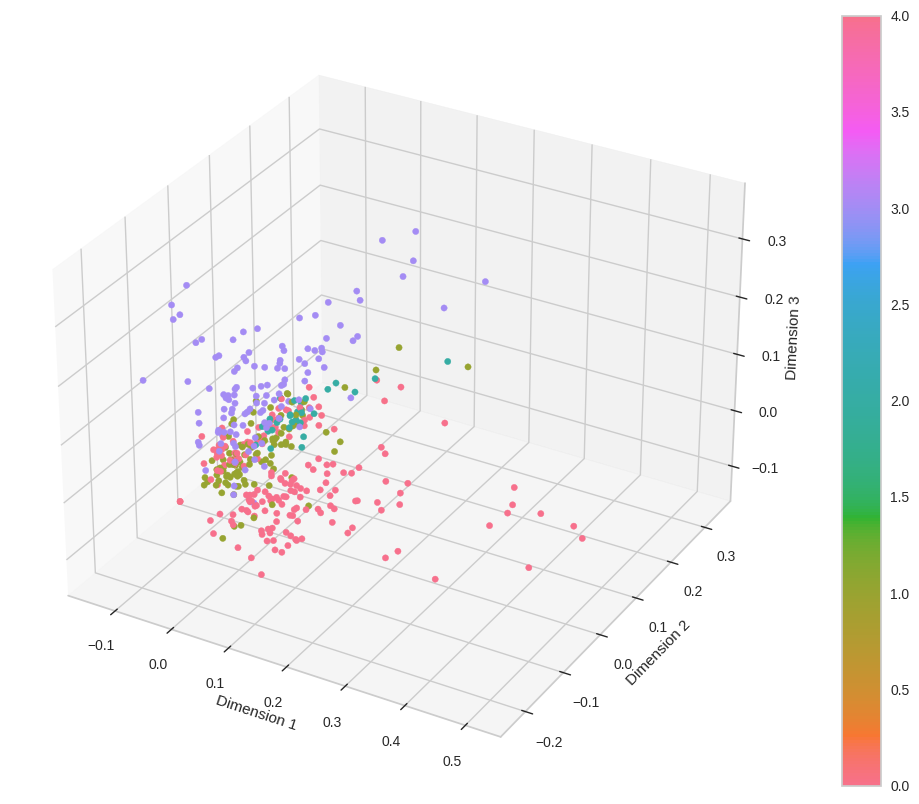

In [94]:
plot_vectors(pca_texts, labels)

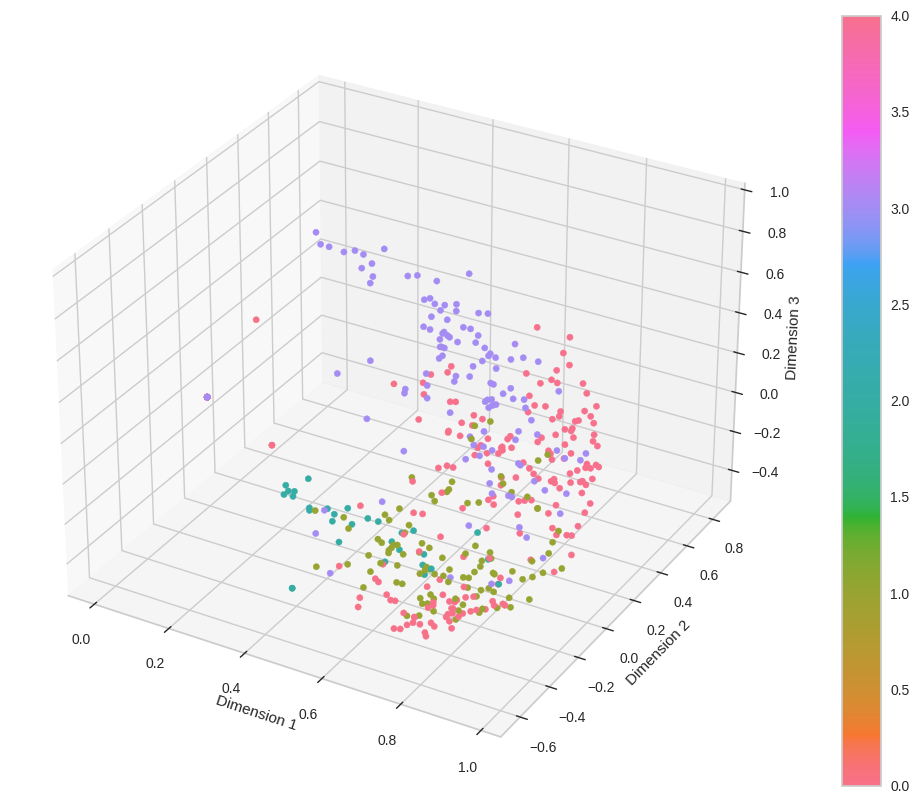

In [95]:
plot_vectors(lsa_texts, labels)

### Dimensionality Reduction: t-SNE and UMAP

t-SNE can project data points down to 2 or 3 dimensions for visualization (see [here](https://distill.pub/2016/misread-tsne/)). Uniform Manifold Approximation and Projection or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) is an alternative to t-SNE, but more effective at preserving global distances, and allows projection to arbitrary numbers of dimensions--2 or 3 for visualization, or 30-50 for effective clustering.

In [96]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
X = TfidfVectorizer().fit_transform(corpus.data)
y = corpus.target

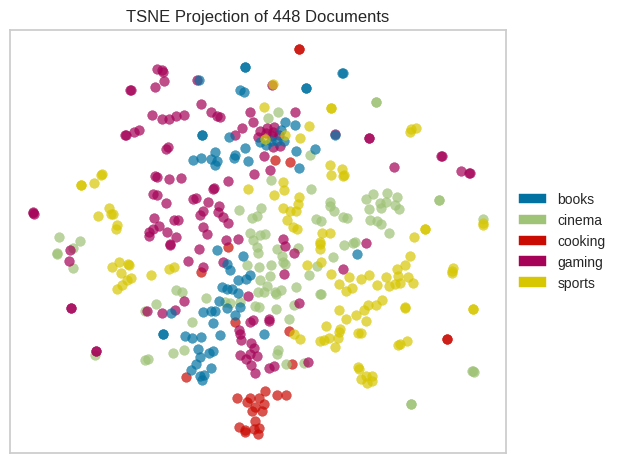

<Axes: title={'center': 'TSNE Projection of 448 Documents'}>

In [97]:
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [98]:
from yellowbrick.text import UMAPVisualizer


In [99]:
umap = UMAPVisualizer()

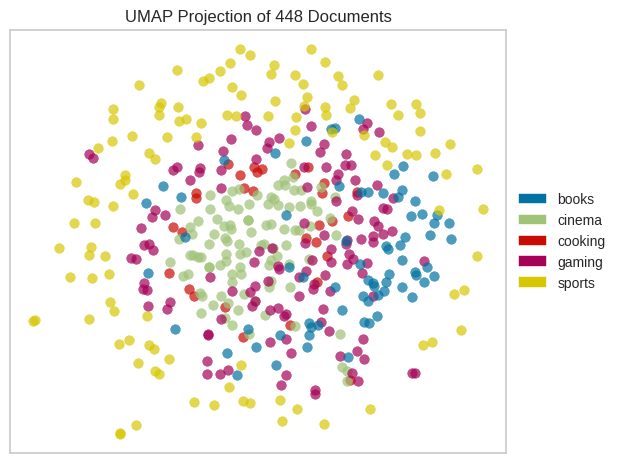

<Axes: title={'center': 'UMAP Projection of 448 Documents'}>

In [100]:
umap.fit(X, y)
umap.show()


We’ve seen in this section how there are a powerful suite of methods available to us which allow us to probe structures in text data before running deep learning algorithms on them. Such exploratory data analysis is an important first step in any kind of data-based problem, and becomes further important when we are working with deep learning problems because they run the risk of sometimes being difficult to interpret. But having a bird’s eye view of the dataset allow us to have a few expectations of what the deep learning models might reveal; and with that knowledge, we can explore what is not obvious and allow neural models to surprise us.


# Neural Embeddings

We'll now start using neural networks - not explicitly, by building models using Keras and PyTorch, but by using different tricks in training models, we can get a network to end up learning different useful notions of semantics - we then use this model's final embedding (or other aspect) to extract useful features for our text data.

## Shallow Neural Embeddings

Word2vec, much like methods like LSA which we saw earlier, is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples. Let’s break this down:

... "use the kitchen knife to chop the vegetables"…

**C1   C2   C3   T   C4   C5   C6   C7**

Here, the target word is knife, and the context words are the ones in its immediate (6-word) window.
The first word2vec method we’ll see is called skipgram, where the task is to assign a probability for how likely it is that the context window appears around the target word. In the training process, positive examples are samples of words and their context words, and negative examples are created by sampling from pairs of words that do not appear nearby one another.

This method of implementing word2vec is called skipgram with negative sampling. So while the algorithm tries to better learn which context words are likely to appear around a target word, it ends up pushing the embedded representations for every word so that they are located optimally (e.g., with minimal semantic distortion). In this process of adjusting embedding values, the algorithm brings semantically similar words close together in the resulting high dimensional space, and dissimilar words far away.

Another word2vec training method, Continuous Bag of Words (CBOW), works in a similar fashion, and tries to predict the target word, given context. This is converse of skipgram, which tries to predict the context, given the target word. Skip-gram represents rare words and phrases well, often requiring more data for stable representations, while CBOW is several times faster to train than the skip-gram, but with slightly better accuracy for the frequent words in its prediction task. The popular gensim implementation of word2vec has both the methods included.

The code below has two examples, one for loading a pre-trained word2vec model, and one for training our own model, with an explanation of the hyperparameters.




### Training Word Embeddings

In the first example, we train a word2vec model on the hobbies dataset with a dimension size of 100 and window of 10, meaning the context window is 10 words. The training process goes through 10 iterations.



In [101]:
from gensim.models import Word2Vec


Here, pre-processed texts is a file we created for our topic models, and includes stemmed words. This is a useful exercise to see how pre-processing effects word2vec models. Recall from earlier sections (and homeworks) that the deeper the model the less pre-processing we need to perform because the model can be trained to perform optimal processing.

NOTE: if using gensim v3.8.3, use "size" for dimension size, and if using v4 +, use "vector_size".

In [102]:
w2vmodel_cleaned = Word2Vec(
        preprocessed_texts,
        vector_size=100,
        window=10)

Let's test the model by looking up some words that we know are in the corpus and find similar words.

In [103]:
w2vmodel_cleaned.wv.most_similar("book")

[('stori', 0.9996196031570435),
 ('page', 0.9995467066764832),
 ('read', 0.9995320439338684),
 ('come', 0.9994822144508362),
 ('origin', 0.9994739890098572),
 ('follow', 0.9994474649429321),
 ('true', 0.9994472861289978),
 ('novel', 0.9994434118270874),
 ('illustr', 0.9994431734085083),
 ('direct', 0.9994426369667053)]

In [104]:
w2vmodel_cleaned.wv.most_similar("talk")

[('awai', 0.9997710585594177),
 ('get', 0.9997629523277283),
 ('took', 0.999748706817627),
 ('mean', 0.9997421503067017),
 ('bring', 0.9997397065162659),
 ('kei', 0.9997367262840271),
 ('chang', 0.9997363090515137),
 ('fan', 0.9997356534004211),
 ('big', 0.9997338652610779),
 ('live', 0.9997324347496033)]

NOTE: it may soon become clear in the next section, but it isn't the best idea to use a corpus with stop words removed. Following from above, we lose a lot of potential relationships we can learn automatically!

We don't always need to train our own models. One of the advantages of word embedding (and many deep learning) models is using pre-trained models, where the training has already been completed on a large and/or representative corpus or document collection. In the following lines of code we load either a [Google News model](https://drive.google.com/file/d/1TW3h1SIx__4Y6zEzLnrPry2Z-6BZgtyh/view?usp=sharing) (3+ GB), or a [model trained on NY Times data](https://drive.google.com/file/d/1xrs1UhTH5LPTBFLcflX-nQ86zwCAoLt5/view?usp=sharing) (30 MB). If you have Colab Pro, you can try the heavier model. I have used the mounting capacity on google drive here. You can also just upload the file if you prefer.

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
model_address = "/content/drive/MyDrive/nytimes_cbow.reduced.txt"

In [109]:
wv = gensim.models.KeyedVectors.load_word2vec_format(model_address)
nytimes_w2v_model = Word2Vec(vector_size=wv.vector_size, min_count=1)
nytimes_w2v_model.build_vocab([wv.index_to_key])

# Assign the vectors to the model’s wv
nytimes_w2v_model.wv.vectors = wv.vectors
nytimes_w2v_model.wv.index_to_key = wv.index_to_key
nytimes_w2v_model.wv.key_to_index = wv.key_to_index

In [110]:
nytimes_w2v_model.wv.most_similar("book")

[('book,', 0.807381272315979),
 ('books', 0.7208226919174194),
 ('memoir', 0.6905068755149841),
 ('novel', 0.6485089063644409),
 ('book.', 0.6376286149024963),
 ('biography', 0.6335102915763855),
 ('novel,', 0.6032705307006836),
 ('memoir,', 0.5900480151176453),
 ('novels', 0.585858166217804),
 ('author', 0.5705239772796631)]

In [111]:
nytimes_w2v_model.wv.most_similar("talk")

[('talking', 0.6718705892562866),
 ('speak', 0.6052849292755127),
 ('talked', 0.5983412265777588),
 ('tell', 0.5425027012825012),
 ('conversation', 0.5362381935119629),
 ('hear', 0.5258073806762695),
 ('know', 0.5096372961997986),
 ('think', 0.4957664906978607),
 ('listen', 0.48267388343811035),
 ('discuss', 0.47418323159217834)]

Note how the most similar words make a lot more sense with the pre-trained, larger, ny times word2vec model. Also note what lemmatizing words can dramatically change the results of word2vec! Why? Because we are removing specificity in context that our model can otherwise learn. The smaller the corpus, the more useful to remove content (e.g., stem); the larger the corpus, the more useful to retain it.

Just so we have a comparison, we also create a non-cleaned corpus of the hobbies dataset on which to build an embedding model.

In [112]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation

In [113]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]

In [114]:
tokenized_texts = []

In [115]:
for doc in corpus.data:
  tokenized_texts.append(preprocess_string(doc, CUSTOM_FILTERS))

In [116]:
tokenized_texts[0][0:10]

['brunch', 'is', 'one', 'of', 'my', 'favorite', 'meals', 'but', 'it', 'often']

NOTE: if using gensim v3.8.3, use "size" for dimension size, and if using v4 +, use "vector_size"

In [117]:
w2vmodel = Word2Vec(tokenized_texts,
        vector_size=100,
        window=10)

### Word and Context Embeddings

The gensim model allows us to access both the target embedding for the word itself, and the context embedding for words. These two embedding are multiplied to recreate the original word space, revealing the way in which neural embeddings perform (and are optimized through) matrix factorization of the original word-by-context matrix. The target embedding is what is most commonly used, though in some cases the context is also used along with the target. We show how to use both.

The context vector is not showcased in the documentation - we unearthed it thanks to this helpful [StackOverflow link](https://stackoverflow.com/questions/39406092/how-to-get-both-the-word-embeddings-vector-and-context-vector-of-a-given-word-by).

In [118]:
book_embedding_ny = nytimes_w2v_model.wv["book"]

In [119]:
book_embedding = w2vmodel.wv["book"]

In [120]:
book_idx = w2vmodel.wv.key_to_index["book"]
book_context_embedding = w2vmodel.syn1neg[book_idx]

In [121]:
book_idx = nytimes_w2v_model.wv.key_to_index["book"]
book_context_embedding_ny = nytimes_w2v_model.syn1neg[book_idx]

### Exploring Semantics with Embeddings

So what do these vectors encapsulate? We've seen before that it is some notion of meaning, as captured by distributional semantics, with some aspect of syntactic information. How do we then use these word embeddings? Because they capture semantic information in a space that allows for semantic decomposition, a common task is to perform semantic arithmetic and analogy tasks.


Find the word that least matches the others within a word set (cosine similarity).

In [122]:
nytimes_w2v_model.wv.doesnt_match(['books', 'books', 'novel', 'memoir', 'truck'])

'truck'

We can also perform arithmetic on vectors using the most_similar function we saw earlier. One of the more popular, earlier examples demonstrating the analogous power of word2vec models was vector['king'] - vector['man'] + vector['woman'] = vector['queen'], where the idea is that we are traversing a "gender" dimension and looking at either end of it.

Let's see how that works on our NY Times model.

In [123]:
nytimes_w2v_model.wv.most_similar(positive=['king', 'woman'], negative = ['man'])

[('royal', 0.5032207369804382),
 ('Queen', 0.464691162109375),
 ('Prince', 0.31866323947906494),
 ('King', 0.296548992395401),
 ('birth', 0.2890930473804474),
 ('daughter', 0.27517256140708923),
 ('marry', 0.24971053004264832),
 ('birthday', 0.24840974807739258),
 ('minister.', 0.248222216963768),
 ('mother.', 0.2480423003435135)]

If we shift ['king'] in the direction of woman, we get to ['royal']...and almost to ['queen'] (try adding woman twice!) Interestingly, ['prince'] is a similarly effeminate royal. We can begin to see the utility of these models, even if they do capture all semantic associations as we might imagine. Larger language models capture even more sophisticated relationships.

In the rest of this section we will see other ways in which we can use and explore word embeddings.

### Visualising Word Embeddings

Most methods involving visualising word embeddings involve projecting words into a lower dimensional space and seeing which words appear nearby one another.

See this [example by TTIC](https://home.ttic.edu/~kgimpel/wordembviz/wordembviz.html) which visualises different sets of word embeddings, using t-SNE.

The code below gives you an idea of how you might do it yourself.

In [124]:
import matplotlib.pyplot as plt

In [125]:
numWords = 50

In [126]:
targetWords = nytimes_w2v_model.wv.index_to_key[200: 200 + numWords]

In [127]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(nytimes_w2v_model.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.458423, -0.05    , -1.300422, ...,  0.587137,  0.089472,
         0.273898],
       [-0.528309, -1.110671, -0.392341, ..., -0.068632, -0.41177 ,
        -0.374877],
       [-1.362821, -0.386514,  0.187103, ...,  0.298058,  0.197425,
         0.702022],
       ...,
       [ 0.666688,  0.666772, -0.928484, ...,  1.247668, -0.683624,
         0.493014],
       [ 0.289133,  0.069201, -0.189002, ...,  1.464237, -1.14469 ,
        -0.077596],
       [-0.044672, -0.48012 , -0.844254, ..., -0.145162, -1.253261,
        -0.010592]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words. We also recommend exploring UMAP, which allows projections to any arbitrary number of dimensions.

In [128]:
import sklearn.decomposition
import sklearn.manifold

In [129]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

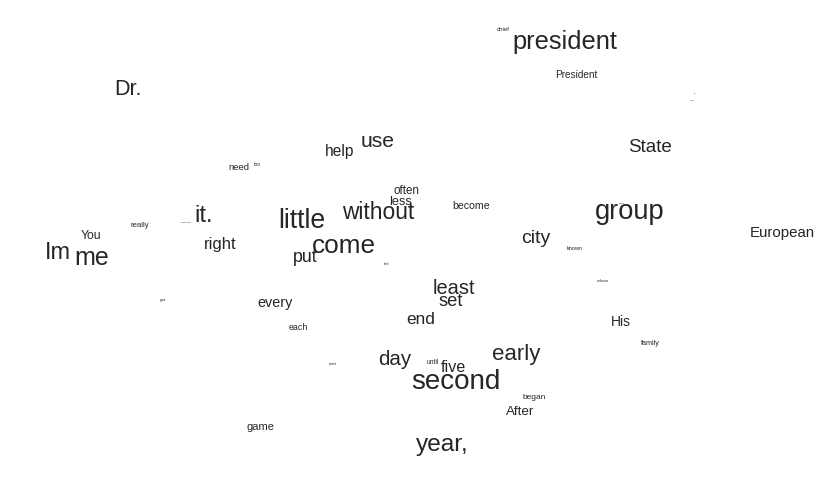

In [130]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Note how the TTIC projection was a lot more satisfactory because it projected related but differentiated words. Our example plots seemingly random words. We encourage that you try this example again with a curated list of words and see how the visualisation improves!

### Projecting Embeddings on Dimensions of Social Analysis

We can see how word2vec does remarkably well in capturing certain aspects of semantics! Word embeddings have a lot of utility outside of just looking at relations between words, though. Because words derive their meanings from various social characteristics and dimensions, it is possible for us to project word vectors onto word-defined dimensions to see where they lie. We can create these dimensions by choosing words which that might anchor the dimension and then project other words onto this dimension. For example, if we were trying to find a gender dimension, we might make a vector between the words he, him, man and she, her, woman, and so on. Then, with a cosine projection, we can get a value of where our word of choice might lie on this dimension, revealing to us how “gendered” the word is. The following snippets of code implements this for various such dimensions. Using such a technique for social scientific analysis as described by Kozlowski et al 2019; it can be very easily extended for many business and analytical solutions.


First we can visualize with dimension reduction

In [131]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_w2v_model.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [132]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

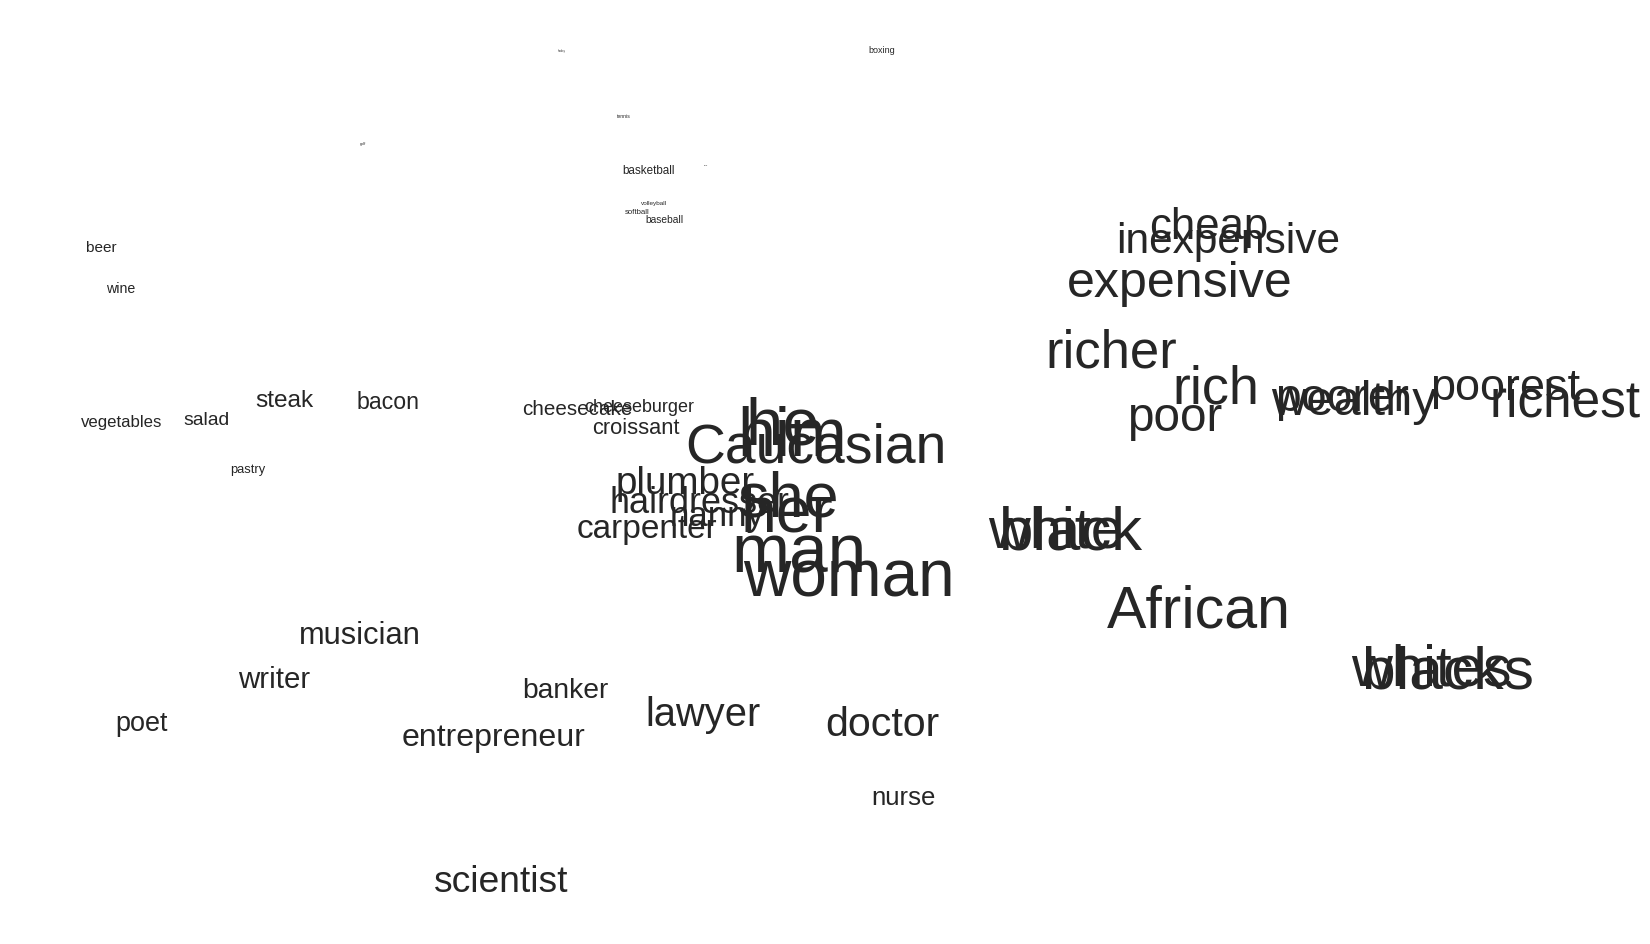

In [133]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible

for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))

plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions.

In [134]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model.wv[x]) for x in positives]) - sum([normalize(model.wv[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [135]:
Gender = dimension(nytimes_w2v_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_w2v_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_w2v_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [136]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [137]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_w2v_model.wv[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_w2v_model.wv[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_w2v_model.wv[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [138]:
OCCdf = makeDF(nytimes_w2v_model, Occupations)
Fooddf = makeDF(nytimes_w2v_model, Foods)
Sportsdf = makeDF(nytimes_w2v_model, Sports)

Define some useful functions for plotting.

In [139]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

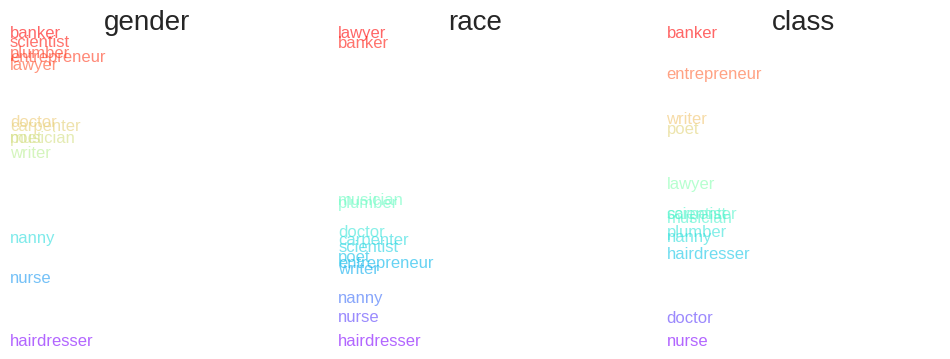

In [140]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

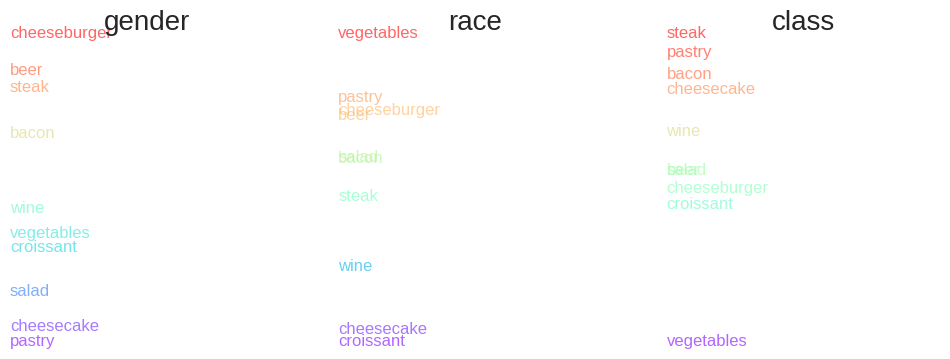

In [141]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

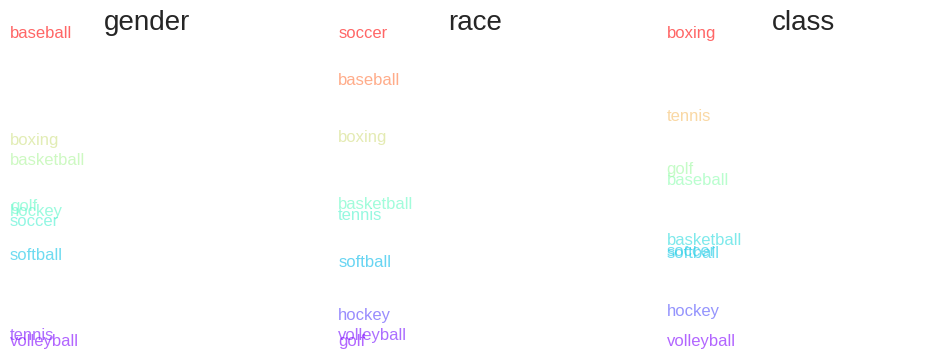

In [142]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

### Debiasing Word Embeddings

As we are creating these dimensions, it may become clear that such an approach may be adapted to measure socio-cultural biases in embeddings. Language models are trained on human generated corpora and text, so they end up reflecting the social and cultural biases present in text (Caliskan et al. 2017). Keeping in mind that the semantics we generate from natural language corpora reflect real world biases which may be harmful (for e.g, in the non modified,  biased models, man:computer programer:: woman:homemaker), there has been significant work in attempting to correct these biases (Bolukbasi et al 2016). These methods work similarly to the projection based methods we explored, and the following code includes code to debias embedding models so that generated associations (e.g., as in a job ad) do not propagate the bias.

In the following section, we use the code from this repository associated with the famous "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings" paper: https://github.com/tolga-b/debiaswe


#### Hands-on Tutorial: Quantifying and Reducing Gender Stereotypes in Word Embeddings

Ensuring fairness in algorithmically-driven decision-making is important to avoid inadvertent cases of bias and perpetuation of harmful stereotypes. However, modern natural language processing techniques, which learn model parameters based on data, might rely on implicit biases presented in the data to make undesirable stereotypical associations. Such a danger faces us with word embeddings, a popular framework to represent text data as vectors which has been used in many machine learning and natural language processing tasks. Recent results ([1](https://arxiv.org/abs/1607.06520), [2](https://arxiv.org/abs/1608.07187)) show that word embeddings trained on a Google News articles exhibit extensive female/male gender stereotypes. This raises concerns because their widespread use may tend to amplify these biases.

In the following, we provide step-by-step instructions to demonstrate and quanitfy the biases in word embedding.



In [143]:
# Setup:
# Clone the code repository from https://github.com/tolga-b/debiaswe.git
!mkdir debiaswe_tutorial
!cd debiaswe_tutorial
!git clone https://github.com/tolga-b/debiaswe.git

# To reduce the time of downloading data, we provide as subset of GoogleNews-vectors in the following location:
# https://drive.google.com/file/d/1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG/view?usp=sharing

# For full embeddings:
# Download embeddings at https://github.com/tolga-b/debiaswe and put them on the following directory
# embeddings/GoogleNews-vectors-negative300-hard-debiased.bin
# embeddings/GoogleNews-vectors-negative300.bin

Cloning into 'debiaswe'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 95 (delta 0), reused 2 (delta 0), pack-reused 91 (from 1)
Receiving objects: 100% (95/95), 60.97 KiB | 20.32 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [144]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np

import debiaswe.debiaswe as dwe
import debiaswe.debiaswe.we as we
from debiaswe.debiaswe.we import WordEmbedding
from debiaswe.debiaswe.data import load_professions

#### Part 1: Gender Bias in Word Embedding


##### Step 1: Load data
We first load the word embedding trained on a corpus of Google News texts consisting of 3 million English words and terms. The embedding maps each word into a 300-dimension vector.

In [145]:
# load google news word2vec
E = WordEmbedding('/content/drive/MyDrive/w2v_gnews_small.txt')      # change this path to the location you uploaded the file

# load professions
professions = load_professions()
profession_words = [p[0] for p in professions]

*** Reading data from /content/drive/MyDrive/w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


#### Step 2: Define gender direction

We define gender direction by the direction of she - he because they are frequent and do not have alternative word senses (e.g., man can also refer to mankind).

In [146]:
# gender direction
v_gender = E.diff('she', 'he')

#### Step 3: Generating analogies of "Man: x :: Woman : y"

We show that the word embedding model generates gender-streotypical analogy pairs.
To generate the analogy pairs, we use an analogy score defined in the paper mentioned above. This score finds word pairs well aligned with gender direction as well as within a short distance from each other to preserve topic consistency.


In [147]:
# analogies gender
a_gender = E.best_analogies_dist_thresh(v_gender)

for (a,b,c) in a_gender:
    print(a+"-"+b)

Computing neighbors
Mean: 10.219732808538016
Median: 7.0
she-he
herself-himself
her-his
woman-man
daughter-son
businesswoman-businessman
girl-boy
actress-actor
chairwoman-chairman
heroine-hero
mother-father
spokeswoman-spokesman
sister-brother
girls-boys
sisters-brothers
queen-king
niece-nephew
councilwoman-councilman
motherhood-fatherhood
women-men
petite-lanky
ovarian_cancer-prostate_cancer
Anne-John
schoolgirl-schoolboy
granddaughter-grandson
aunt-uncle
matriarch-patriarch
twin_sister-twin_brother
mom-dad
lesbian-gay
husband-younger_brother
gal-dude
lady-gentleman
sorority-fraternity
mothers-fathers
grandmother-grandfather
blouse-shirt
soprano-baritone
queens-kings
Jill-Greg
daughters-sons
grandma-grandpa
volleyball-football
diva-superstar
mommy-kid
Sarah-Matthew
hairdresser-barber
softball-baseball
goddess-god
Aisha-Jamal
waitress-waiter
princess-prince
filly-colt
mare-gelding
ladies-gentlemen
childhood-boyhood
interior_designer-architect
nun-priest
wig-beard
granddaughters-grandso

#### Step 4: Analyzing gender bias in word vectors asscoiated with professions

Next, we show that many occupations are unintendedly associated with either male of female by projecting their word vectors onto the gender dimension.

The script will output the profession words sorted with respect to the projection score in the direction of gender.

In [148]:
# profession analysis gender
sp = sorted([(E.v(w).dot(v_gender), w) for w in profession_words if w in E.index])

sp[0:20], sp[-20:]

([(-0.23798442, 'maestro'),
  (-0.21665451, 'statesman'),
  (-0.2075867, 'skipper'),
  (-0.20267202, 'protege'),
  (-0.2020676, 'businessman'),
  (-0.19492392, 'sportsman'),
  (-0.18836352, 'philosopher'),
  (-0.18073659, 'marksman'),
  (-0.1728986, 'captain'),
  (-0.16785558, 'architect'),
  (-0.16702037, 'financier'),
  (-0.16313638, 'warrior'),
  (-0.15280862, 'major_leaguer'),
  (-0.15001443, 'trumpeter'),
  (-0.14718868, 'broadcaster'),
  (-0.14637241, 'magician'),
  (-0.14401694, 'fighter_pilot'),
  (-0.13782284, 'boss'),
  (-0.137182, 'industrialist'),
  (-0.13684885, 'pundit')],
 [(0.19714224, 'interior_designer'),
  (0.2083344, 'housekeeper'),
  (0.21560377, 'stylist'),
  (0.2236317, 'bookkeeper'),
  (0.23776126, 'maid'),
  (0.24125955, 'nun'),
  (0.2478258, 'nanny'),
  (0.24929331, 'hairdresser'),
  (0.24946159, 'paralegal'),
  (0.25276464, 'ballerina'),
  (0.25718823, 'socialite'),
  (0.26647124, 'librarian'),
  (0.27317625, 'receptionist'),
  (0.2754029, 'waitress'),
  (0.2

#### Part 2 Racial Bias

##### Step 5: Define racial direction
We define racial direction based on the common names in different Demographic groups.

In [153]:
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
names_group1 = [names[2 * i] for i in range(len(names) // 2)]
names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]

In [154]:
# racial direction
vs = [sum(E.v(w) for w in names if w in E.index) for names in (names_group2, names_group1)]
vs = [v / np.linalg.norm(v) for v in vs]

v_racial = vs[1] - vs[0]
v_racial = v_racial / np.linalg.norm(v_racial)

#### Step 6: Generating racial biased analogies

Similar to Step 3, we generate analogies that align with the racial dimension.

In [155]:
# racial analogies
a_racial = E.best_analogies_dist_thresh(v_racial)

for (a,b,c) in a_racial:
    print(a+"-"+b)

Sarah-Keisha
defensemen-cornerbacks
hipster-hip_hop
punter-cornerback
singer_songwriter-rapper
defenseman-defensive_tackle
pole_vault-triple_jump
musicians-artistes
musician-artiste
catcher-wide_receiver
rock_n_roll-reggae
kicker-kick_returner
tavern-barbershop
freestyle_relay-meter_hurdles
lefthander-swingman
bacon-fried_chicken
artists-rappers
equipment-equipments
hockey-basketball
wool-cotton
unassisted_goal-layup
chocolates-sweets
buddy-cousin
priest-preacher
blue-black
medley_relay-meter_dash
quirky-funky
rabbi-imam
grapes-mango
telecommunications-telecommunication
pitchers-defensive_linemen
passages-verses
er-o
acoustic-soulful
punting-punt_returns
thefts-armed_robbery
bar-nightclub
digs-rebounds
Greg-Geoffrey
cellist-saxophonist
smarts-quickness
puck-halfcourt
quarterback-tailback
fox-leopard
pedophiles-rapists
potatoes-flour
en-el
infrastructure-infrastructural
evangelism-gospel
fiance-aunt
pointers-dunks
baseman-defensive_lineman
pedophile-rapist
joked-smiled
beer-soft_drink
g

#### Step 7: Analyzing racial bias in word vectors asscoiated with professions

Similar to Step 4, we project occpurations onto the racial dimension.

In [156]:
# profession analysis racial
sp = sorted([(E.v(w).dot(v_racial), w) for w in profession_words])

sp[0:20], sp[-20:]

([(-0.3154624, 'artiste'),
  (-0.2736962, 'shopkeeper'),
  (-0.27285585, 'taxi_driver'),
  (-0.2424875, 'cab_driver'),
  (-0.230962, 'preacher'),
  (-0.21709055, 'boxer'),
  (-0.2097353, 'laborer'),
  (-0.20361683, 'barber'),
  (-0.19625022, 'cleric'),
  (-0.18273096, 'bodyguard'),
  (-0.18250424, 'gangster'),
  (-0.18162958, 'singer'),
  (-0.1687708, 'maid'),
  (-0.16871038, 'entertainer'),
  (-0.16197535, 'cabbie'),
  (-0.15332884, 'housewife'),
  (-0.14839591, 'civil_servant'),
  (-0.14115772, 'policeman'),
  (-0.13648951, 'minister'),
  (-0.13296558, 'drug_addict')],
 [(0.08779256, 'organist'),
  (0.09007452, 'philanthropist'),
  (0.09135294, 'cinematographer'),
  (0.093180254, 'manager'),
  (0.09358392, 'investment_banker'),
  (0.09687842, 'professor_emeritus'),
  (0.09782898, 'curator'),
  (0.09864862, 'freelance_writer'),
  (0.099171564, 'programmer'),
  (0.10142015, 'screenwriter'),
  (0.10198847, 'author'),
  (0.10438656, 'inventor'),
  (0.1067784, 'adventurer'),
  (0.10964736

#### Practice

Repeat Step 2-4 with debiased word embedding.

You can use debiaswe debias function to do the debiasing with word sets of your choosing

You can leave equalize_pairs and gender_specific_words blank when coming up with your own groups. We give an example for the case of gender below for you to warm up.

<font color="red">Resolving the `ModuleNotFoundError: No module named 'debiaswe.debiasewe'` Issue</font>

If you encounter the error `ModuleNotFoundError: No module named 'debiaswe.debiasewe'`, follow these steps to resolve it:

1. Navigate to the `debiaswe` directory, then to the nested `debiaswe` folder, and open the `debiaswe.py` file.
2. Locate **line 2** in the file.
3. Replace the following line:

   ```python
   import we
   ```
   with:
   ```python
   from . import we
   ```

In [160]:
from debiaswe.debiaswe.debias import debias

In [161]:
# Lets load some gender related word lists to help us with debiasing
with open('debiaswe/data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('debiaswe/data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('debiaswe/data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]
gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [162]:
debias(E, gender_specific_words, defs, equalize_pairs)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
{('DAD', 'MOM'), ('CONGRESSMAN', 'CONGRESSWOMAN'), ('MEN', 'WOMEN'), ('Brother', 'Sister'), ('SCHOOLBOY', 'SCHOOLGIRL'), ('Gelding', 'Mare'), ('Spokesman', 'Spokeswoman'), ('Nephew', 'Niece'), ('spokesman', 'spokeswoman'), ('male', 'female'), ('Prostate_Cancer', 'Ovarian_Cancer'), ('kings', 'queens'), ('wives', 'husbands'), ('FATHER', 'MOTHER'), ('Father', 'Mother'), ('Men', 'Women'), ('himself', 'herself'), ('DADS', 'MOMS'), ('Man', 'Woman'), ('twin_brother', 'twin_sister'), ('grandfather', 'grandmother'), ('Schoolboy', 'Schoolgirl'), ('MALES', 'FEMALES'), ('HIMSELF', 'HERSELF'), ('Businessman', 'Businesswoman'), ('grandpa', 'grandma'), ('dudes', 'gals'), ('man', 'woman'), ('Congressman', 'Congresswoman'), ('KINGS', 'QUEENS'), ('GELDING', 'MARE'), ('catholic_priest', 'nun'), ('GRANDPA', 'GRANDMA'), ('MONASTERY', 'CONVENT'), ('Males', 'Females'), ('Chairman', 'Chairwoman'), ('sons', 'daughters'), ('boy', 

In [163]:
# profession analysis gender
sp_debiased = sorted([(E.v(w).dot(v_gender), w) for w in profession_words])

sp_debiased[0:20], sp_debiased[-20:]

([(-0.4196325, 'congressman'),
  (-0.4067585, 'businessman'),
  (-0.32398775, 'councilman'),
  (-0.30967084, 'dad'),
  (-0.21665451, 'statesman'),
  (-0.11345412, 'salesman'),
  (-0.073004864, 'monk'),
  (-0.07216395, 'handyman'),
  (-0.049468253, 'minister'),
  (-0.043583866, 'archbishop'),
  (-0.04020722, 'bishop'),
  (-0.038332477, 'commissioner'),
  (-0.035724368, 'surgeon'),
  (-0.033134002, 'trader'),
  (-0.03237721, 'observer'),
  (-0.032095835, 'neurosurgeon'),
  (-0.0314501, 'priest'),
  (-0.03113396, 'skipper'),
  (-0.029659163, 'lawmaker'),
  (-0.02951123, 'commander')],
 [(0.029965684, 'teenager'),
  (0.030237047, 'instructor'),
  (0.030946163, 'student'),
  (0.031116994, 'paralegal'),
  (0.03203944, 'bookkeeper'),
  (0.03243464, 'cinematographer'),
  (0.034329094, 'graphic_designer'),
  (0.03470567, 'lifeguard'),
  (0.03566654, 'janitor'),
  (0.035971913, 'drummer'),
  (0.04212018, 'wrestler'),
  (0.04390225, 'hairdresser'),
  (0.04813317, 'firefighter'),
  (0.23776129, 'm

In [164]:
# analogies gender
a_gender_debiased = E.best_analogies_dist_thresh(v_gender)

for (a,b,c) in a_gender_debiased:
    print(a+"-"+b)

Computing neighbors
Mean: 10.218597434053665
Median: 7.0
she-he
grandma-grandpa
ex_boyfriend-ex_girlfriend
queens-kings
mothers-fathers
mare-gelding
councilwoman-councilman
schoolgirl-schoolboy
moms-dads
sister-brother
females-males
twin_sister-twin_brother
filly-colt
husbands-wives
estrogen-testosterone
girls-boys
ladies-gentlemen
grandmother-grandfather
niece-nephew
queen-king
granddaughter-grandson
aunt-uncle
gals-dudes
mother-father
spokeswoman-spokesman
ovarian_cancer-prostate_cancer
sisters-brothers
daughters-sons
granddaughters-grandsons
herself-himself
girl-boy
businesswoman-businessman
chairwoman-chairman
female-male
woman-man
congresswoman-congressman
women-men
daughter-son
sorority-fraternity
motherhood-fatherhood
convent-monastery
princess-prince
her-his
mom-dad
actress-actor
lesbian-gay
compatriot-countryman
husband-younger_brother
gal-dude
hers-theirs
heroine-protagonist
feminism-feminist
actresses-actors
childhood-boyhood
waitress-waiter
kid-guy
me-him
mommy-daddy
aunts-

### Retrofitting Word Vectors

We can debias word embeddings (or try to, at least) based on how we can move word vectors around in this high dimensional space. Word2vec and related methods are static in that they are trained only once and word vectors don’t change based on context. Nevertheless, research by (Faruqui et al. 2015) has shown that we can improve the performance of word embeddings on a series of tasks by retrofitting them, which involves using an external lexicon (collection of words) to move certain words closer together or farther apart. While the authors use this to improve performance on a series of semantic tasks, we can be creative in how we want to retrofit our embeddings. Below are instructions for performing this kind of task.

This is taken from the repository from the paper cited above:
Retrofitting word vectors: https://github.com/mfaruqui/retrofitting

For the [retrofit.py](https://github.com/mfaruqui/retrofitting/blob/master/retrofit.py) file, use this link. The code is also copy pasted in the code cell below this.

#### Data you need

Word vector file
Lexicon file (provided here)
Each vector file should have one word vector per line as follows (space delimited):-

the -1.0 2.4 -0.3 ...

#### Running the program

python retrofit.py -i word_vec_file -l lexicon_file -n num_iter -o out_vec_file

python retrofit.py -i sample_vec.txt -l lexicons/ppdb-xl.txt -n 10 -o out_vec.txt

where, 'n' is an integer which specifies the number of iterations for which the optimization is to be performed. Usually n = 10 gives reasonable results.

#### Output File: out_vec.txt

which are your new retrofitted and (hopefully) improved word vectors, enjoy !



In [167]:
import argparse
import gzip
import math
import numpy
import re
import sys

from copy import deepcopy

isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')

  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = numpy.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)

  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w')
  for word, values in wordVectors.iteritems():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      outFile.write('%.4f' %(val)+' ')
    outFile.write('\n')
  outFile.close()

''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
  lexicon = {}
  for line in open(filename, 'r'):
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

''' Retrofit word vectors to a lexicon '''
def retrofit(wordVecs, lexicon, numIters):
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the data estimate if the number of neighbours
      newVec = numNeighbours * wordVecs[word]
      # loop over neighbours and add to new vector (currently with weight 1)
      for ppWord in wordNeighbours:
        newVec += newWordVecs[ppWord]
      newWordVecs[word] = newVec/(2*numNeighbours)
  return newWordVecs

if __name__=='__main__':

  parser = argparse.ArgumentParser()
  parser.add_argument("-i", "--input", type=str, default=None, help="Input word vecs")
  parser.add_argument("-l", "--lexicon", type=str, default=None, help="Lexicon file name")
  parser.add_argument("-o", "--output", type=str, help="Output word vecs")
  parser.add_argument("-n", "--numiter", type=int, default=10, help="Num iterations")
  args = parser.parse_args()

  wordVecs = read_word_vecs(args.input)
  lexicon = read_lexicon(args.lexicon)
  numIter = int(args.numiter)
  outFileName = args.output

  ''' Enrich the word vectors using ppdb and print the enriched vectors '''
  print_word_vecs(retrofit(wordVecs, lexicon, numIter), outFileName)

### Aligning Word Embeddings

We've explored alignment in some detail in tutorial 2.2, on Data Integration and Alignment. Specifically, we looked at alignment across time and across languages -  in this section, we will revisit these examples.


NOTE: the following section has previously seen code.

#### Time based data

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists. You can download the data [here](https://drive.google.com/file/d/1R9EiThdJQ3vY84xcoPJGUBeqvemu_o8L/view?usp=sharing).

In [181]:
from tqdm.notebook import tqdm
tqdm.pandas()

ascoDF = pd.read_csv("/content/ASCO_abstracts.csv", index_col=0, on_bad_lines='skip', delimiter=',')
# to speed up...
ascoDF = ascoDF.sample(frac=0.05, random_state=60615)

In [182]:
# This may take quite a while to finish....
# Tokenize sentences with a progress bar
ascoDF['tokenized_sents'] = ascoDF['Body'].progress_apply(
    lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)]
)

# Normalize tokens with a progress bar
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].progress_apply(
    lambda x: [lucem_illud.normalizeTokens(s) for s in x]
)

  0%|          | 0/4868 [00:00<?, ?it/s]

  0%|          | 0/4868 [00:00<?, ?it/s]

In [183]:
import copy

#### Cross Temporal Alignment

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic change as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf).

In this case we train the models ourselves instead of using a pre-trained model, so this might take some time.

In [196]:
def calc_vectors_norm(model):
    """
    Returns a manually normalized version of the Gensim model's vectors
    as a (num_words x embedding_dim) numpy array.
    """
    vectors = model.wv.vectors
    # If your model hasn't yet built vectors, you might need to handle that separately
    norms = np.sqrt((vectors ** 2).sum(axis=1, keepdims=True))
    return (vectors / norms).astype(np.float32)

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two Gensim 4+ Word2Vec models m1 and m2 so they share the same vocabulary.
    If `words` is given, intersect that list/set as well.
    The models' vectors, key_to_index, and index_to_key are updated in place.

    Returns (m1, m2).
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.key_to_index.keys())
    vocab_m2 = set(m2.wv.key_to_index.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1.intersection(vocab_m2)
    if words:
        common_vocab = common_vocab.intersection(set(words))

    # If the vocab is already identical, just return
    if (vocab_m1 == common_vocab) and (vocab_m2 == common_vocab):
        return (m1, m2)

    # Otherwise, sort by descending frequency
    # Gensim 4+ stores counts in model.wv.get_vecattr(word, "count") (if available)
    def total_count(word):
        return (m1.wv.get_vecattr(word, "count") or 0) + \
               (m2.wv.get_vecattr(word, "count") or 0)

    common_vocab = list(common_vocab)
    common_vocab.sort(key=total_count, reverse=True)

    # Rebuild each model so it has only the common vocabulary
    for model in [m1, m2]:
        old_key_to_index = model.wv.key_to_index
        old_vectors = model.wv.vectors
        old_norms = calc_vectors_norm(model)  # We'll use this to preserve alignment

        # Identify the rows (indices) that correspond to the common vocab words
        indices = [old_key_to_index[w] for w in common_vocab]

        # Rebuild the main vectors
        new_vectors = old_norms[indices]
        model.wv.vectors = new_vectors
        model.wv.vectors_norm = None  # Force recalculation if needed

        # Rebuild key_to_index and index_to_key
        model.wv.key_to_index = {}
        model.wv.index_to_key = []
        for new_idx, word in enumerate(common_vocab):
            model.wv.key_to_index[word] = new_idx
            model.wv.index_to_key.append(word)

        # If you want to keep track of counts, you can also do something like:
        # for word in common_vocab:
        #     old_count = model.wv.get_vecattr(word, "count")
        #     if old_count is not None:
        #         model.wv.set_vecattr(word, "count", old_count)

    return (m1, m2)


def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Procrustes-align two Gensim 4+ Word2Vec models (for comparing same words across models).

    1. Intersect their vocabularies (and optionally intersect with `words`).
    2. Align the `other_embed` model to the `base_embed` model via Procrustes.
    3. Modify `other_embed` in place and return it.
    """

    # Make (shallow) copies so we don't edit the originals
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)

    # 1. Intersect the vocabularies
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # 2. Get the normalized vectors from both
    base_vecs = calc_vectors_norm(in_base_embed)
    other_vecs = calc_vectors_norm(in_other_embed)

    # Dot product and SVD
    m = np.dot(other_vecs.T, base_vecs)
    u, _, v = np.linalg.svd(m)
    ortho = np.dot(u, v)  # orthogonal transformation

    # Apply the transformation to other_embed's vectors
    new_other_vecs = np.dot(calc_vectors_norm(other_embed), ortho)
    other_embed.wv.vectors = new_other_vecs
    other_embed.wv.vectors_norm = None  # reset, so Gensim can recalc norms if needed

    return other_embed

In [197]:
def compareModels(df, category, sort=True):
    """
    Example function that trains a separate Word2Vec model for each distinct
    value of `df[category]`, then aligns them pairwise via Procrustes.
    """

    embeddings_raw = {}
    cats = sorted(set(df[category]))

    # Train a model per category (simplified example)
    for cat in cats:
        print(f"Embedding {cat}", end='\r')
        subsetDF = df[df[category] == cat]
        # Adjust Word2Vec parameters to your preference
        model = Word2Vec(
            sentences=subsetDF['normalized_sents'].sum(),
            vector_size=100,  # or any dimension you like
            min_count=1,
            workers=4
        )
        embeddings_raw[cat] = model

    # Align each model to the first model in cats, for instance
    embeddings_aligned = {}
    for outer_cat in cats:
        # Start with the base
        base_model = embeddings_raw[outer_cat]
        embeddings_aligned[outer_cat] = [base_model]
        for inner_cat in cats:
            if inner_cat == outer_cat:
                continue
            aligned = smart_procrustes_align_gensim(
                embeddings_aligned[outer_cat][-1],
                embeddings_raw[inner_cat]
            )
            embeddings_aligned[outer_cat].append(aligned)

    return embeddings_raw, embeddings_aligned

In [198]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

This is the key to our aligning - the smart procrustes align method here is the one doing the aligning, and we are adding the alligned embeddings to the dictionary.

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [211]:
def getDivergenceDF(word, embeddingsDict):
    """
    Computes absolute (1 - cosine_similarity) for `word` between a 'base' model
    (index 0 in each category list) and each subsequent model (aligned versions).

    Parameters
    ----------
    word : str
        Target word.
    embeddingsDict : dict
        {
            category: [model_base, model_aligned1, model_aligned2, ...],
            ...
        }
        Each value is a list of Word2Vec models.

    Returns
    -------
    pd.DataFrame
        Rows are categories, columns are each aligned model's divergence from the base.
    """
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity

    cats = sorted(embeddingsDict.keys())
    dists = {}

    for cat in cats:
        # Safety check: does this category have at least one model?
        if len(embeddingsDict[cat]) == 0:
            dists[cat] = []
            continue

        # The first model is our "base" model
        base_model = embeddingsDict[cat][0]

        # Retrieve base vector for the target word
        # Make sure the word actually exists in the vocabulary
        if word not in base_model.wv:
            # If missing, store something (e.g., np.nan) or skip
            dists[cat] = []
            continue

        base_vec = base_model.wv[word].reshape(1, -1)

        # Compare against all subsequent models in this category
        cat_dists = []
        for aligned_model in embeddingsDict[cat][1:]:
            if word not in aligned_model.wv:
                # If the word doesn't exist in that model, handle it
                cat_dists.append(np.nan)
                continue

            aligned_vec = aligned_model.wv[word].reshape(1, -1)
            cos_sim = cosine_similarity(base_vec, aligned_vec)[0, 0]
            divergence = np.abs(1 - cos_sim)
            cat_dists.append(divergence)

        dists[cat] = cat_dists

    # Each category's row in the DataFrame shows divergences for that category
    # across the aligned models (in order).
    return pd.DataFrame.from_dict(dists, orient='index')

In [212]:
import matplotlib.pyplot as plt

In [213]:
import seaborn

We now check certain words and see their movement in time along these abstracts.

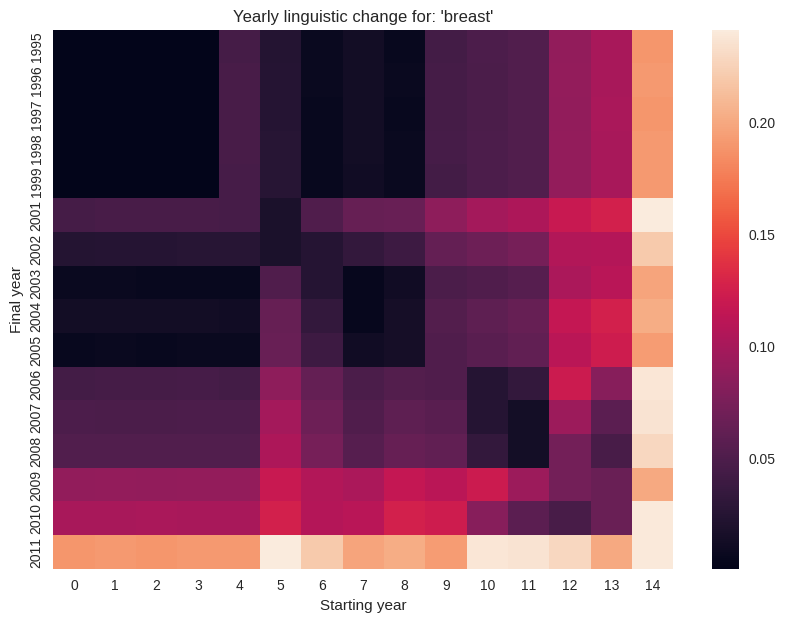

In [214]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

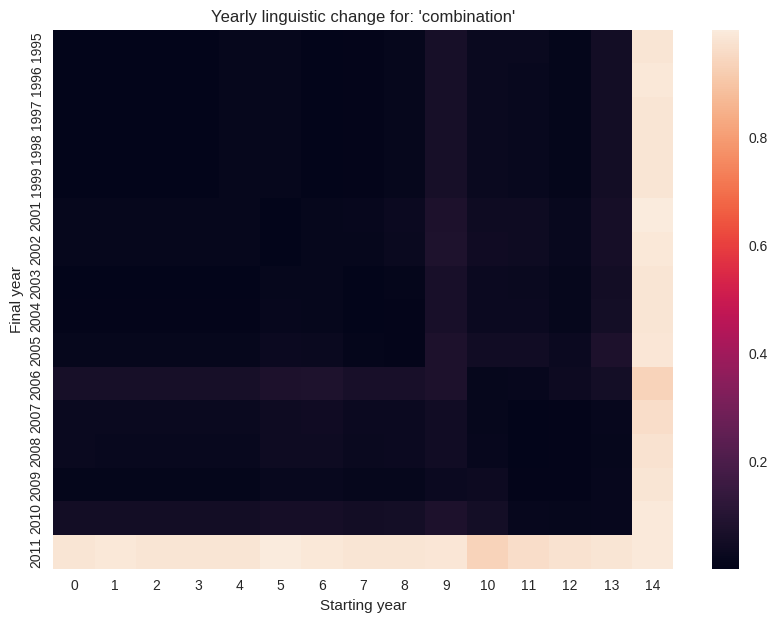

In [215]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [221]:
from sklearn.metrics.pairwise import cosine_similarity

def findDiverence(word, embeddingsDict):
    """
    Computes the sum of (1 - cosine_similarity) between the 'base' model
    in the first category and all aligned models (if any).
    """
    cats = sorted(embeddingsDict.keys())
    if not cats:
        return 0.0

    # 'Base' model is the first model in embeddingsDict[cats[0]]
    base_models = embeddingsDict[cats[0]]
    if not base_models:
        return 0.0

    base_model = base_models[0]

    dists = []
    # Compare 'base_model' vs. each aligned model in [1:]
    for aligned_model in base_models[1:]:
        if (word in base_model.wv) and (word in aligned_model.wv):
            base_vec = base_model.wv[word].reshape(1, -1)
            aligned_vec = aligned_model.wv[word].reshape(1, -1)
            cos_sim = cosine_similarity(base_vec, aligned_vec)[0, 0]
            dists.append(1 - cos_sim)
        else:
            # Optionally handle missing words differently (e.g., skip or np.nan)
            pass

    return sum(dists)

def findMostDivergent(embeddingsDict):
    """
    Finds the word(s) with the largest sum of (1 - cosine_similarity)
    across all categories’ base/aligned models.
    """
    # Collect all unique words from all models
    all_words = []
    for cat_models in embeddingsDict.values():
        for model in cat_models:
            # In Gensim 4+, model.wv.key_to_index is a dict of {word: index}
            all_words.extend(list(model.wv.key_to_index.keys()))
    all_words = set(all_words)

    print(f"Found {len(all_words)} words to compare")

    # Compute and store (word, divergence_value) for each unique word
    word_divs = []
    for w in all_words:
        div_value = findDiverence(w, embeddingsDict)
        word_divs.append((w, div_value))

    # Sort by divergence descending
    return sorted(word_divs, key=lambda x: x[1], reverse=True)

In [222]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 768 words to compare


In [223]:
wordDivergences[:20]

[('abc', 14.310080874711275),
 ('adjustment', 13.299685991369188),
 ('gender', 11.614159293472767),
 ('bowel', 11.374976351857185),
 ('randomized', 10.66436941921711),
 ('randomization', 9.907312460243702),
 ('margin', 9.721760496497154),
 ('pathologic', 9.446203097701073),
 ('effectiveness', 9.288539867149666),
 ('mei', 9.128047917038202),
 ('difficult', 8.825655654072762),
 ('accrue', 8.802548587322235),
 ('encourage', 8.418364509940147),
 ('recommendation', 8.074826553463936),
 ('evident', 7.929533369839191),
 ('avoid', 7.896331405267119),
 ('vinorelbine', 7.725278809666634),
 ('pelvic', 7.463423818349838),
 ('univariate', 7.417424142360687),
 ('separate', 7.2961758598685265)]

In [224]:
wordDivergences[-20:]

[('vs', 0.46396756172180176),
 ('gene', 0.44718289375305176),
 ('value', 0.444360613822937),
 ('include', 0.44056493043899536),
 ('outcome', 0.4171783924102783),
 ('study', 0.40720129013061523),
 ('measure', 0.4046538472175598),
 ('test', 0.39664387702941895),
 ('show', 0.3550052046775818),
 ('significant', 0.34567737579345703),
 ('compare', 0.3423006534576416),
 ('tissue', 0.3338963985443115),
 ('treatment', 0.3332214951515198),
 ('analysis', 0.3260335326194763),
 ('early', 0.31327110528945923),
 ('tumor', 0.30840003490448),
 ('use', 0.30060774087905884),
 ('assess', 0.2954646348953247),
 ('associate', 0.29492437839508057),
 ('low', 0.2678413987159729)]

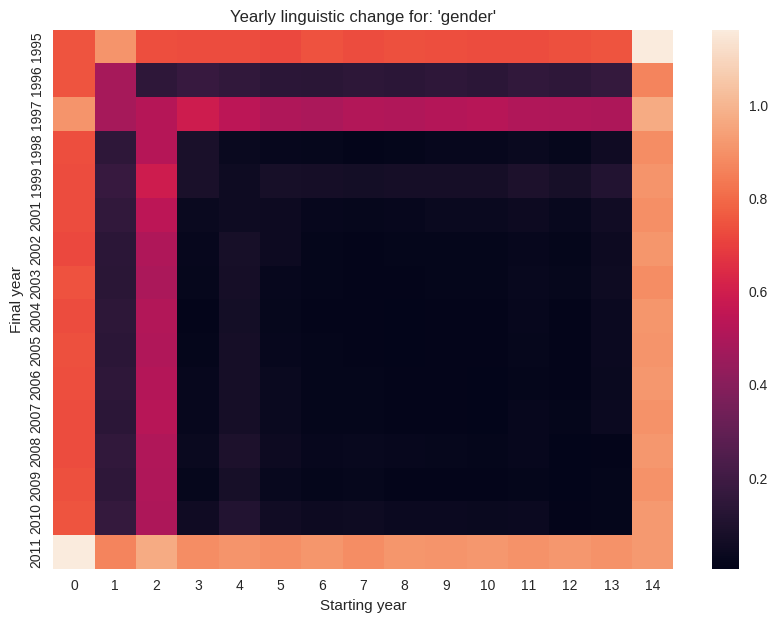

In [225]:
targetWord = wordDivergences[2][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

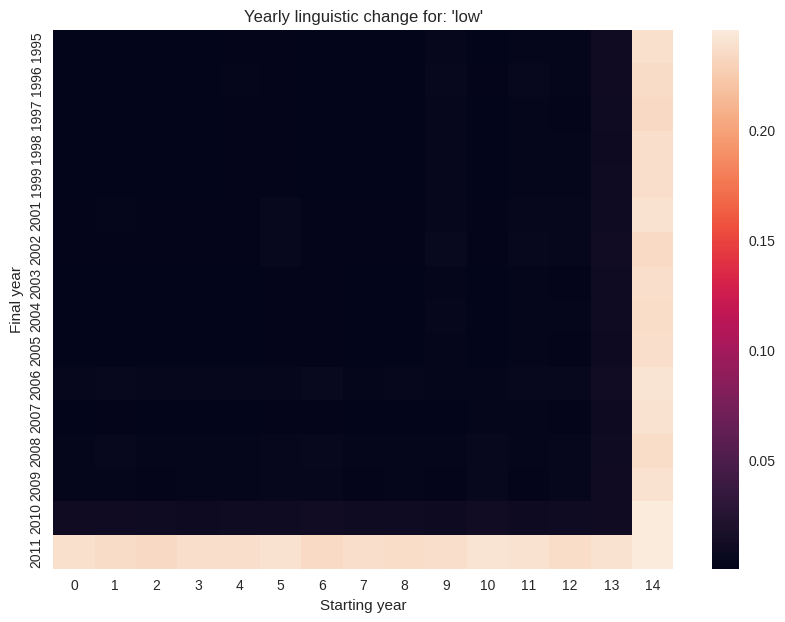

In [226]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

We've seen here from a small, research based corpus how it is still able to capture some notion of semantic drift. The word cell has moved among the most and the word view has moved the least. We recommend trying similar analyses on different datasets to see how words change their meaning over time based on the company they keep.

#### Cross language alignment

While in the previous example we saw how we can use a time-stamped textual corpus to create embeddings and then compare between them, in the following example we use pre-trained embeddings for different languages and align them using some powerful packages.

Here, we use Fast Text word embeddings downloaded from their [documentation website](https://fasttext.cc/), for Spanish and French embeddings. Fast Text does not take the word as a special unit but rather the character window, allowing it to achieve more subtle contextual information. You must download these embeddings and upload them to be able to complete this part of the exercise. Note that these files are large! If it doesn't work, restart your session, clear your uploads and try this section again.

We then perform an SVD and orthogonal transformation on the data to rotate and reflect it so that it best aligns.
The code is adapted from:
https://github.com/babylonhealth/fastText_multilingual

In [248]:
import io
# !rm -r fastText

In [249]:
!pip install fasttext
import fasttext

In [250]:
# fr_dictionary = fasttext.load_model(vector_file='/content/wiki.fr.vec')


In [251]:
# es_dictionary = fasttext.load_model(vector_file='/content/wiki.es.vec')

In [252]:
# fr_vector = fr_dictionary["chat"]
# es_vector = es_dictionary["gata"]

In [253]:
# print(fasttext.cosine_similarity(fr_vector, es_vector))

In [254]:
# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

To align the two word embeddings, we must try and find some common words with similar meanings. Lets try this by simply going through some common dictionaries.

In [255]:
# es_words = set(es_dictionary.word2id.keys())
# fr_words = set(fr_dictionary.word2id.keys())
# overlap = list(es_words & fr_words)
# bilingual_dictionary = [(entry, entry) for entry in overlap]

In [256]:
# len(bilingual_dictionary)

In [257]:
# form the training matrices
# source_matrix, target_matrix = make_training_matrices(fr_dictionary, es_dictionary, bilingual_dictionary)

In [258]:
# learn and apply the transformation
# transform = learn_transformation(source_matrix, target_matrix)
# fr_dictionary.apply_transform(transform)

In [260]:
# fr_vector = fr_dictionary["chat"]
# es_vector = es_dictionary["gata"]
# print(FastVector.cosine_similarity(fr_vector, es_vector))

Here, we see that by simply picking up words spelled the same, we have done a decent job in aligning the two spaces - the Spanish word for cat and French word for cat are closer than they were in the previously unaligned space. Try using an actual Spanish - French dictionary next time and see how well the embeddings end up aligning!


#### Deep Canonical Alignment

Aligning word embeddings is a popular task: here is some more material on aligning embeddings in different contexts, as well as a more efficient deep canonical alignment.

[Deep Canonical Alignment](http://proceedings.mlr.press/v28/andrew13.html)

https://github.com/Michaelvll/DeepCCA

https://github.com/mfaruqui/crosslingual-cca



In [261]:
# code for deep CCA

### Dynamic Word Embeddings

While some temporal analysis with word embedding models create seperate embedding spaces for different time periods and align them, it is also possible to train all these embeddings in the same space, by assuming a _drift_ between each time period, simily to a dynamic topic model. Recently, it was shown in Bamler and Mandt (2017)(‘dynamic skip-gram’ model) and Yao et al. (2018) (‘dynamic Word2Vec’ model) that it is possible to learn the word embeddings across several time periods jointly, enforcing alignment across all of them simultaneously, and positioning all the models in the same vector space in one step.  This develops the idea of model alignment even further and eliminates the need to first learn separate embeddings for each time period, and then align subsequent model pairs. Of course, it also hides idiosyncratic differences between time periods.

- [Dynamic Word Embeddings for Evolving Semantic Discovery](https://arxiv.org/abs/1703.00607), Yao et al, [GitHub implementation](https://github.com/yifan0sun/DynamicWord2Vec)

- [Dynamic Word Embeddings](https://arxiv.org/pdf/1702.08359.pdf), Balmer and Mandt, [GitHub Implementation](https://github.com/accessai/dynamic_word_embeddings)

- [Dynamic Bernoulli Embeddings for Language Evolution](https://arxiv.org/abs/1703.08052), Rudolph and Blei, [GitHub Implementation](https://github.com/EvanZhuang/dynamic-clustering-of-dynamic-embeddings)

The code below implements a version of this.

The example input files can be downloaded at: [Dropbox link](
https://www.dropbox.com/s/nifi5nj1oj0fu2i/data.zip?dl=0)

The input is the word_pair_PMIs, which is stored in csvs (ignore the mat files); you need to put them all in a path and load everything from there (change the 'training head' variable).

In [268]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 13:10:42 2016

"""

# main script for time CD
# trainfile has lines of the form
# tok1,tok2,pmi

import numpy as np
import util_timeCD as util
import pickle as pickle

# PARAMETERS

nw = 20936 # number of words in vocab (11068100/20936 for ngram/nyt)
T = range(1990,2016) # total number of time points (20/range(27) for ngram/nyt)
cuda = True

trainhead = 'data/wordPairPMI_' # location of training data
savehead = 'results/'

def print_params(r,lam,tau,gam,emph,ITERS):

    print('rank = {}'.format(r))
    print('frob  regularizer = {}'.format(lam))
    print('time  regularizer = {}'.format(tau))
    print('symmetry regularizer = {}'.format(gam))
    print('emphasize param   = {}'.format(emph))
    print('total iterations = {}'.format(ITERS))

if __name__=='__main__':
    import sys
    ITERS = 5 # total passes over the data
    lam = 10 #frob regularizer
    gam = 100 # forcing regularizer
    tau = 50  # smoothing regularizer
    r   = 50  # rank
    b = nw # batch size
    emph = 1 # emphasize the nonzero

    foo = sys.argv
    for i in range(1,len(foo)):
        if foo[i]=='-r':    r = int(float(foo[i+1]))
        if foo[i]=='-iters': ITERS = int(float(foo[i+1]))
        if foo[i]=='-lam':    lam = float(foo[i+1])
        if foo[i]=='-tau':    tau = float(foo[i+1])
        if foo[i]=='-gam':    gam = float(foo[i+1])
        if foo[i]=='-b':    b = int(float(foo[i+1]))
        if foo[i]=='-emph': emph = float(foo[i+1])
        if foo[i]=='-check': erchk=foo[i+1]


    savefile = savehead+'L'+str(lam)+'T'+str(tau)+'G'+str(gam)+'A'+str(emph)

    print('starting training with following parameters')
    print_params(r,lam,tau,gam,emph,ITERS)
    print('there are a total of {} words, and {} time points'.format(nw,T))

    print('X*X*X*X*X*X*X*X*X')
    print('initializing')

    #Ulist,Vlist = util.initvars(nw,T,r, trainhead)
    Ulist,Vlist = util.import_static_init(T)
    print(Ulist)
    print(Vlist)
    print('getting batch indices')
    if b < nw:
        b_ind = util.getbatches(nw,b)
    else:
        b_ind = [range(nw)]

    import time
    start_time = time.time()
    # sequential updates
    for iteration in range(ITERS):
        print_params(r,lam,tau,gam,emph,ITERS)
        try:
            Ulist = pickle.load(open( "%sngU_iter%d.p" % (savefile,iteration), "rb" ) )
            Vlist = pickle.load(open( "%sngV_iter%d.p" % (savefile, iteration), "rb" ) )
            print('iteration %d loaded succesfully' % iteration)
            continue
        except(IOError):
            pass
        loss = 0
        # shuffle times
        if iteration == 0: times = T
        else: times = np.random.permutation(T)

        for t in range(len(times)):   # select a time
            print('iteration %d, time %d' % (iteration, t))
            f = trainhead + str(t) + '.csv'
            print(f)

            """
            try:
                Ulist = pickle.load( open( "%sngU_iter%d_time%d_tmp.p" % (savefile,iteration,t), "rb" ) )
                Vlist = pickle.load( open( "%sngV_iter%d_time%d_tmp.p" % (savefile, iteration,t), "rb" ) )
                times = pickle.load( open( "%sngtimes_iter%d_time%d_tmp.p" % (savefile, iteration,t), "rb" ) )
                print 'iteration %d time %d loaded succesfully' % (iteration, t)
                continue
            except(IOError):
                pass
            """

            pmi = util.getmat(f,nw,False)
            for j in xrange(len(b_ind)): # select a mini batch
                print('%d out of %d' % (j,len(b_ind)))
                ind = b_ind[j]
                ## UPDATE V
                # get data
                pmi_seg = pmi[:,ind].todense()

                if t==0:
                    vp = np.zeros((len(ind),r))
                    up = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vp = Vlist[t-1][ind,:]
                    up = Ulist[t-1][ind,:]
                    iflag = False

                if t==len(T)-1:
                    vn = np.zeros((len(ind),r))
                    un = np.zeros((len(ind),r))
                    iflag = True
                else:
                    vn = Vlist[t+1][ind,:]
                    un = Ulist[t+1][ind,:]
                    iflag = False
                Vlist[t][ind,:] = util.update(Ulist[t],emph*pmi_seg,vp,vn,lam,tau,gam,ind,iflag)
                Ulist[t][ind,:] = util.update(Vlist[t],emph*pmi_seg,up,un,lam,tau,gam,ind,iflag)


            #pickle.dump(Ulist, open( "%sngU_iter%d_time%d_tmp.p" % (savefile,iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)
            #pickle.dump(Vlist, open( "%sngV_iter%d_time%d_tmp.p" % (savefile, iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)
            #pickle.dump(times, open( "%sngtimes_iter%d_time%d_tmp.p" % (savefile, iteration,t), "wb" ) , pickle.HIGHEST_PROTOCOL)


            ####  INNER BATCH LOOP END

        # save
        print('time elapsed = ', time.time()-start_time)


        pickle.dump(Ulist, open( "%sngU_iter%d.p" % (savefile,iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)
        pickle.dump(Vlist, open( "%sngV_iter%d.p" % (savefile, iteration), "wb" ) , pickle.HIGHEST_PROTOCOL)


In [269]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 10 10:11:23 2016

@author: raon
"""

#utility functions for running the CD method
#loss: min 1/2 \sum_t | Yt - UtVt' |^2 + lam/2 \sum_t(|Ut|^2 + |Vt|^2) +
#                                        tau/2 \sum_t>1(|Vt - Vt-1|^2 + |Ut - Ut-1|^2)
#                                        gam/2 \sum_t (|Ut - Vt|^2)

import numpy as np
import scipy.io as sio
import copy
def update(U,Y,Vm1,Vp1,lam,tau,gam,ind,iflag):

    UtU = np.dot(U.T,U) # rxr
    r = UtU.shape[0]
    if iflag:   M   = UtU + (lam + 2*tau + gam)*np.eye(r)
    else:       M   = UtU + (lam + tau + gam)*np.eye(r)

    Uty = np.dot(U.T,Y) # rxb
    Ub  = U[ind,:].T   # rxb
    A   = Uty + gam*Ub + tau*(Vm1.T+Vp1.T)  # rxb
    Vhat = np.linalg.lstsq(M,A) #rxb
    return Vhat[0].T #bxr


#for the above function, the equations are to update V. So:
#Y is n X b (b = batch size)
#r = rank
#U is n X r
#Vm1 and Vp1 are bXr. so they are b rows of V, transposed

def import_static_init(T):
    emb = sio.loadmat('data/emb_static.mat')['emb']
    U = [copy.deepcopy(emb) for t in T]
    V = [copy.deepcopy(emb) for t in T]
    return U,V
def initvars(vocab_size,T,rank):
    # dictionary will store the variables U and V. tuple (t,i) indexes time t and word index i

    U,V = [],[]
    U.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    V.append(np.random.randn(vocab_size,rank)/np.sqrt(rank))
    for t in xrange(1,T):
        U.append(U[0].copy())
        V.append(V[0].copy())
        print t
    return U,V

import pandas as pd
import scipy.sparse as ss
def getmat(f,v,rowflag):
    data = pd.read_csv(f)
    data = data.as_matrix()

    X = ss.coo_matrix((data[:,2],(data[:,0],data[:,1])),shape=(v,v))


    if rowflag:
        X = ss.csr_matrix(X)
        #X = X[inds,:]
    else:
        X = ss.csc_matrix(X)
        #X = X[:,inds]

    return X#.todense()

def getbatches(vocab,b):
    batchinds = []
    current = 0
    while current<vocab:
        inds = range(current,min(current+b,vocab))
        current = min(current+b,vocab)
        batchinds.append(inds)
    return batchinds

#   THE FOLLOWING FUNCTION TAKES A WORD ID AND RETURNS CLOSEST WORDS BY COSINE DISTANCE
from sklearn.metrics.pairwise import cosine_similarity
def getclosest(wid,U):
    C = []
    for t in range(len(U)):
        temp = U[t]
        K = cosine_similarity(temp[wid,:],temp)
        mxinds = np.argsort(-K)
        mxinds = mxinds[0:10]
        C.append(mxinds)
    return C

# THE FOLLOWING FUNCTIONS COMPUTES THE REGULARIZER SCORES GIVEN U AND V ENTRIES
def compute_symscore(U,V):
    return np.linalg.norm(U-V)**2

def compute_smoothscore(U,Um1,Up1):
    X = np.linalg.norm(U-Up1)**2 + np.linalg.norm(U-Um1)**2
    return X


## Adding more context - FastText and GloVE

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText (Bojanowski et al. 2017), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents.

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [270]:
! pip install fasttext

### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [google drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing).

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [271]:
import fasttext

In [279]:
file_address = "/content/fil9"

In [ ]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

In [ ]:
model.save_model("result/fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

You still get a word vector for it! But how good it is? Let's find out in the next sections!

#### Nearest neighbor queries
A simple way to check the quality of a word vector is to look at its nearest neighbors. This gives an intuition of the type of semantic information the vectors are able to capture.

This can be achieved with the nearest neighbor (nn) functionality. For example, we can query the 10 nearest neighbors of a word by running the following command:

In [ ]:
model.get_nearest_neighbors('asparagus')

Nice! It seems that vegetable vectors are similar. Note that the nearest neighbor is the word asparagus itself, this means that this word appeared in the dataset. What about Pokemons?

In [ ]:
model.get_nearest_neighbors('pidgey')

Different evolution of the same Pokemon have close-by vectors! But what about our misspelled word; is its vector close to anything reasonable? Let's find out:

In [ ]:
model.get_nearest_neighbors('enviroment')

Thanks to the information contained in the word, the vector of our misspelled word matches reasonable words! It is not perfect but the main information has been captured.

#### Measure of similarity

In order to find nearest neighbors, we need to compute a similarity score between words. Our words are represented by continuous word vectors and we can thus apply simple similarities to them. In particular we use the cosine of the angles between two vectors. This similarity is computed for all words in the vocabulary, and the 10 most similar words are shown. Of course, if the word appears in the vocabulary, it will appear on top, with a similarity of 1.

Word analogies
In a similar spirit, one can play around with word analogies. For example, we can see if our model can guess what is to France as Berlin is to Germany.

This can be done with the analogies functionality. It takes a word triplet (like Germany Berlin France) and outputs the analogy:



In [ ]:
model.get_analogies("berlin", "germany", "france")

The answer provided by our model is Paris, which is correct. Let's have a look at a less obvious example:



In [ ]:
model.get_analogies("psx", "sony", "nintendo")

Our model considers that the nintendo analogy of a psx is the gamecube, which seems reasonable. Of course the quality of the analogies depend on the dataset used to train the model; one can only hope to cover domains well-represented in the dataset.

#### Importance of character n-grams
Using subword-level information is particularly interesting to build vectors for unknown words. For example, the word gearshift does not exist on Wikipedia but we can still query its closest existing words:

In [ ]:
model.get_nearest_neighbors('gearshift')


Most of the retrieved words share substantial substrings but a few are actually quite different, like cogwheel. You can try other words like sunbathe or grandnieces.

Now that we have seen the interest of subword information for unknown words, let's check how it compares to a model that does not use subword information. To train a model without subwords, just run the following command:

In [ ]:
model_without_subwords = fasttext.train_unsupervised('data/fil9', maxn=0)

To illustrate the difference, let us take an uncommon word in Wikipedia, like accomodation which is a misspelling of accommodation. Here is the nearest neighbors obtained without subwords:

In [ ]:
model_without_subwords.get_nearest_neighbors('accomodation')

The result does not make much sense, most of these words are unrelated. On the other hand, using subword information gives the following list of nearest neighbors:

In [ ]:
model.get_nearest_neighbors('accomodation')

The nearest neighbors captures different variations around the word accommodation. We also get semantically related words such as amenities or catering.

#### Conclusion

In this section, we show how to obtain word vectors from Wikipedia. This can be done for any language and we provide [pre-trained models](https://fasttext.cc/docs/en/pretrained-vectors.html) with the default setting for 294 of them.

### FastText Aligned Embeddings and Vectors

The FastText website has an incredible resource, outside of the rich documentation and examples - pre-trained word vectors for 157 different languages! This is great because it allows for comparisons between languages, and an opportunity for us to search for structural similarities across languages. One of the ways we can do this is by aligning embeddings, similar to what we did for the diachronic temporal embeddings. We already saw code for aligning FastText embeddings using an unsupervised method (dictionary), and in the code below we will exploring embeddings that are already aligned. You can find code to perform the alignment in an [unsupervised](https://github.com/facebookresearch/fastText/blob/master/alignment/unsup_align.py) way, as well as [supervised](https://github.com/facebookresearch/fastText/blob/master/alignment/align.py). (Joulin et al, 2018)

Remember to first download the two files!

#### Loading word embeddings

In [ ]:
import io
import numpy as np

In [ ]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [ ]:
src_path = '/content/vectors-en.txt'
tgt_path = '/content/vectors-es.txt'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

#### Get nearest neighbors

In [ ]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [ ]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

In [ ]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

#### Visualize multilingual embeddings

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

In [ ]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

In [ ]:
# get 5 random input words
src_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

### GloVE

While word2vec and FastText focus on the local context of words, there are also methods which also attend to global corpus statistics. The most popular embedding model from this family is GloVe (Pennington et al., 2014), which gets its name from its approach to the embeddings - Global Vectors. It also includes information of ratios of probabilities from the word-word co-occurence matrix, which make it powerful for measuring semantic similarity, while still being able to capture the linear sub-structure (which we construct our dimensions with, and do our algebraic operations on). Below is code for loading GloVe vectors using gensim, and straight into a dictionary.

You can download pre-trained GloVe vectors here: https://nlp.stanford.edu/projects/glove/

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_file = datapath('/content/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

In [ ]:
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [ ]:
model.most_similar('obama')

In [ ]:
model.most_similar('banana')

In [ ]:
model.most_similar(negative='banana')

In [ ]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

In [ ]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
analogy('japan', 'japanese', 'australia')


In [ ]:
analogy('australia', 'beer', 'france')


In [ ]:
analogy('obama', 'clinton', 'reagan')


In [ ]:
analogy('tall', 'tallest', 'long')


In [ ]:
analogy('good', 'fantastic', 'bad')


In [ ]:
print(model.doesnt_match("breakfast cereal dinner lunch".split()))


In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [ ]:
display_pca_scatterplot(model,
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])


In [ ]:
display_pca_scatterplot(model, sample=300)

### svd2vec

GloVe attempts to use the best of both local and global information (although we note that its performance is comparable to word2vec, which only accounts for local information). Count-based information is built on older methods such as PMI, which stands for Pointwise Mutual Information (Fano 1961) - these measures are built by trying to identify the chances of two events occuring at the same time, and can be refashioned to think about target and context words. There has been further work showing that dense embeddings such as word2vec have a strong relationship with matrix factorisation like processes that use PMI, where word2vec can be seen as implicitly optimizing a shifted version of a PMI matrix (Levy and Goldberg 2015). This work has been taken forward in Levy et al 2015, where they use PMI and SVD to generate vectors comparable to those from word2vec. Below is code for using such methods with the package svd2vec.

In [ ]:
! pip install svd2vec

We've seen a few corpora so far - the small hobbies corpus, and the wikipedia corpus. We will use the Wikipedia corpus for training this model, as it is more suited to training a language model. While we could directly feed the raw file to train it for FastText, svd2vec requires it to be similar to the gensim format, which is a list of lists representing the corpus.

In [ ]:
from svd2vec import svd2vec


In [ ]:
wiki_texts = []

In [ ]:
for line in open("/content/drive/MyDrive/fil9"):
  # this is an example of generating a corpus - you can use your own!
  wiki_texts.append(line)
  break

In [ ]:
# code to clean files

In [ ]:
# creating the words representation (can take a while)
svd = svd2vec(wiki_texts, window=5, min_count=100, verbose=False)

In [ ]:
svd.similarity("bad", "good")


In [ ]:
svd.similarity("monday", "friday")


In [ ]:
svd.distance("apollo", "moon")


In [ ]:
svd.most_similar(positive=["january"], topn=2)


In [ ]:
svd.analogy("paris", "france", "berlin")


In [ ]:
svd.analogy("road", "cars", "rail", topn=5)


This sort of matrix decomposition can be as powerful as word2vec - please follow this [notebook tutorial](https://valentinp72.github.io/svd2vec/gensim_comparison.html) for a demonstration comparing it to the gensim word2vec algorithm on the same corpus.

## Deep Learning and Computational Linguistics

Now that we have our doc object, what can we do with it?
We can see that the doc object now contains the entire corpus. This is important because we will be using this doc object to create our corpus for the machine learning algorithms. When creating a corpus for gensim/scikit-learn, we sometimes forget the incredible power which spaCy packs in its pipeline, so we will briefly demonstrate the same in this section with a smaller example sentence. Keep in mind that whatever we can do with a sentence, we can also do with the entire corpus.

spaCy does all of this using a powerful but light weight deep learning langauge model under the hood!

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [ ]:
from spacy import displacy

Simple enough sentence, right? When we pass any kind of text through the spaCy pipeline, it becomes annotated. We will quickly have a look at the 3 most important of capabilities which spaCy provides - POS-tagging, NER-tagging, and dependency parsing.

#### POS-Tagging

In [ ]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

#### NER-Tagging

In [ ]:
for token in sent:
    print(token.text, token.ent_type_)

In [ ]:
for ent in sent.ents:
    print(ent.text, ent.label_)

In [ ]:
displacy.render(sent, style='ent', jupyter=True)

#### Dependency Parsing

In [ ]:
for chunk in sent.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
          chunk.root.head.text)


In [ ]:
for token in sent:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])


In [ ]:
displacy.render(sent, style='dep', jupyter=True)

## NOTE: Where are the deep neural nets?

So far, we've seen concepts heavily related to and linked to deep learning, but not actually used deep learning for text. In the following sections, we will begin to see deep models used in more obvious ways.

We have also already seen an example of deep learning for text, but in the last week - when we used a bi directional LSTM to classify text documents. A reminder - LSTMs are a recurrent neural network which are well suited to language based tasks.

While we will continue our mode of using pre-trained models and popular packages to extract sentence and paragraph vectors, some of these methods include an LSTM (and more) under the hood!

In [ ]:
# empty cell

## Sentence, paragraph, and document embeddings

Word embeddings caught on so popularly not just because of their ability to semantically and/or syntactically represent individual words, but because of their utility as building blocks for more complex natural language and text related tasks. Apart from the kinds analysis we've seen, word embeddings are used in text classification and clustering tasks, information retrieval tasks, and as the internal representations for more complex deep neural models (which we will see in the coming sections and chapter).

Most of the time, word embeddings are used in these tasks to create some form of sentence, paragraph or document embeddings. These representations are then used in downstream task. The process of putting these embeddings together can be thought of as a vector space composition task - how do we put together these vectors to represent a sentence or larger collection of words? Earlier approaches doing this involved attempts at building linguistically informed vector space addition and multiplication models (Mitchell and Lapata (2008) , Baroni and Zamparelli (2010), (Mitchell and Lapata 2010)), but composition now often takes a deep learning approach, and there are a variety of ways to create these representations, each with their advantages and weaknesses.

### Non neural representations


In this section, we start with some very simple ways to create sentence and document representations, before moving on to neural network based methods. We saw some of these methods for creating representations earlier in the notebook, where we used simple counting methods (bag of words), weighted metrics (TF-IDF), and topic models. Some of these ways of representing longer texts may be very sparse, so we can also perform a dimensionality reduction technique on them such as PCA.

Because we already saw the implementation using TF-IDF, SVD/PCA, Random Projection and HDP, the code below demonstrates using the ldamodel we created for the hobbies data.

In [ ]:
preprocessed_texts = preprocess_documents(corpus.data)
dictionary = Dictionary(preprocessed_texts)
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]

model = LdaModel(corpus, id2word=dictionary, num_topics=5, minimum_probability=1e-8)

In [ ]:
rep = model[corpus]

In [ ]:
rep[0]

Here we see a case of documents being represented as their distribution of topics, based on the topic model we created. You might remember that our topic model wasn't the most informative - you will have to adapt between different neural methods to see what best suits your data and question. It can often be useful to baseline your neural method approach requiring distinct assumptions and assurances.

### Averaging word vectors

Before the advent of deep learning for text, most text-based systems would use some form of the representations we just observed. But with word2vec (an admittedly shallow neural network), words capture complex semantic content, which means that documents and paragraphs could begin to use this rich information. There are a couple of different approaches to creating document and paragraph embeddings which treat word2vec vectors like concepts. The first two we will see use word embeddings directly to create the representation for longer combinations of words. A naive (but still useful and sometimes more robust!) way to create sentence embeddings is to simply average all the word embeddings in a sentence.

In [ ]:
def create_vector(text, model, model_type=None):
    if model_type == "word2vec":
        vectors = []
        for word in text:
            try:
                vectors.append(model.wv[word])
            except KeyError:
                pass
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)

In [ ]:
hobbie_vector = create_vector(tokenized_texts[0], w2vmodel)

In [ ]:
hobbie_vector

### More than just averaging

This doesn’t always work out the best though -  as sentences get longer, we run the risk of getting a massive semantic blob as opposed to something which captures fine grained semantics. There are ways around this, and the work by Arora et al (2017) , titled ‘A simple but tough-to-beat baseline for sentence embeddings’ is a good example of using word embeddings while still creating meaningful sentence embeddings. They compute the weighted average of the word vectors in the sentence and then remove the projections of the average vectors on their first principal component (“common component removal”). The weighted average here is similar to TF-IDF, modified for better empirical performance. What is remarkable is despite only performing simple operations on word embeddings, these sentence embeddings outperform more complex architectures such as RNNs specifically built for sentence embeddings. The following code uses a package called Fast Sentence Embeddings (similar to gensim) which creates sentence representations using this technique.

[Fast Sentence Embedding](https://github.com/oborchers/Fast_Sentence_Embeddings)

[Sentence2vec package (alternative)](https://github.com/peter3125/sentence2vec)


In [ ]:
!pip install -U git+https://github.com/oborchers/Fast_Sentence_Embeddings

NOTE: this package only works with gensim version 3.8.3, which includes the Keyedvector class.

In [ ]:
import gensim

In [ ]:
from fse.models import Average
from fse import IndexedList

In [ ]:
model = Average(w2vmodel)

In [ ]:
model.train(IndexedList(tokenized_texts))


In [ ]:
corpus.target[0]

In [ ]:
corpus.target[1]

In [ ]:
corpus.target[400]

In [ ]:

model.sv.similarity(0,1)

In [ ]:
model.sv.similarity(0,400)

It's a small corpus with similar language so we don't see a remarkable difference, but we do see that documents with similar labels have closer similarities. We recommend exploring the package and their alternative sentence embedding methods.

### RNN powered Inference for Sentence Vectors

Another popular setting to learn such embeddings is using captioned images to learn a “grounded” representation of sentence meaning. The work by (Kiela et al. 2018) is from the same team that came up with NLI based sentence embeddings, and uses captioned images from the popular COCO dataset (which we encountered in Homework 3). In the code below, we use their code and package, InferSent to create and evaluate sentence embeddings. This embedding space is referred to as a universal sentence encoder, and these families of methods are also called sentence encoders because of their use of encoder-decoder architectures.

Code for sentence embeddings and inference
 https://github.com/facebookresearch/InferSent


There are 2 versions of InferSent. Version 1 uses GLovE while version 2 uses FastText vectors. You can choose to work with either model. Thus, we download the InferSent Model and the pre-trained Word Vectors. For this, please first save the models.py file from here and store it in your working directory.

We also need to save the trained model and pre-trained GLoVe word vectors. According to the code below, our working directory should have an ‘encoders’ folder and a folder called ‘GLoVe’. The encoder folder will have our model while the GloVe folder should have the word vectors:


In [ ]:
! mkdir encoder
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

! mkdir GloVe
! curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip GloVe/glove.840B.300d.zip -d GloVe/

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
from models import InferSent
import torch

V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = '/content/GloVe/glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

In [ ]:
model.build_vocab(corpus.data, tokenize=True)


In [ ]:
query = "I love to play video games"
query_vec = model.encode(query)[0]


In [ ]:
query_vec

In [ ]:
similarity = []
for sent in corpus.data[0:10]:
  sim = cosine(query_vec, model.encode([sent])[0])
  print("Sentence = ", sent, "; similarity = ", sim)

You can play around with the queries and corpus to check out more similarity metrics.

### Universal Sentence Encoder

Google has also come up with a [universal sentence encoder](https://arxiv.org/abs/1803.11175) (Cer et al. 2018) model based on similar supervised classification settings, and has shared the model via tensorflow hub making it easy to use.

We can download this universal sentence encoder using tensorflow hub. You can also check this useful [blog post](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:~:text=The%20Universal%20Sentence%20Encoder%20encodes,and%20other%20natural%20language%20tasks.&text=It%20comes%20with%20two%20variations,Deep%20Averaging%20Network%20(DAN).) for production level uses.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [ ]:
sentence_embeddings = model(tokenized_texts)
query = "I had pizza and pasta"
query_vec = model([query])[0]

In [ ]:
for sent in sentences:
  sim = cosine(query_vec, model([sent])[0])
  print("Sentence = ", sent, "; similarity = ", sim)

### Doc2Vec

So far we’ve seen unsupervised aggregation methods, and self-supervised methods that use a specific task to help learn a sentence embedding space. The last popular class of embeddings we will look at are unsupervised methods which can also be used to learn larger text embeddings such as paragraphs and documents. For larger documents, the same tasks and settings are not quite as relevant. One of the earliest (and to this day, very popular) method for creating document embeddings is often referred to as doc2vec (Le and Mikolov, 2014, Lau and Baldwin 2016). It is inspired by word2vec, also has two training processes, Distributed Memory and Distributed Bag of Words. DM attempts to use an encoder-decoder model as well as a “memory vector” for the document, and each word in the document is given a vector representation, as well as the document itself. These vectors are then used to predict a single word based on its context. The D-BOW method uses a single document to predict whether a series of sampled words are from the document in question. The popular gensim implementation includes both methods and works well.

Instead of just looking at just how words embed within the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pd.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words.

In [ ]:
apsD2V.docvecs[1952]

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**!

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra:

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

In [ ]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5)

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

### Skip Thought

There exist many methods inspired by word2vec (and other embedding algorithms) which create embeddings for sentences and paragraphs. A notable method is skip-thought (Kiros et al, 2015) and the related FastSent which attempt to predict the entire sentence context based on the sentence in question. By doing this, sentences that share semantic and syntactic properties are mapped to similar vector representations. We do not explore this method in detail, but one can download the required model via the official GitHub repository, and use the model with just a few lines of code.

https://github.com/ryankiros/skip-thoughts

In [ ]:
# code to run model is in the GitHub link

### Word Mover's Distance and Embeddings

The last method we will explore in this section uses word embeddings to create distance measures between documents in a high dimensional space. Inspired by the Earth Mover’s (or discrete Wasserstein) Distance metric used to measure between points in space, Word Mover’s Distance (Kusner et al, 2015) measures the dissimilarity between two text documents as the minimum amount of distance that the embedded words of one document need to “travel” in the embedding space to reach the embedded words of another document. The best part of WMD is that we don’t need either of the sentences we compare to have any common words. Gensim’s implementation of Word Mover’s Distance works well and can be useful in building information retrieval systems built on word embeddings.

(code for WMD - https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html)

Building on this method, IBM built a sentence encoder inspired by WMD that goes beyond just distances in space towards encoding sentences using word embeddings and a distance measure. This embedding method is called Word Movers Embeddings, and there exists a C++ based python wrapper of the code, which we link to but do not demonstrate in this section.  Word mover embedding -  https://github.com/IBM/WordMoversEmbeddings


In [ ]:
# code to run models are in the GitHub link

## Classification and topic extraction with word embeddings

In this section we will explore the use of word and document embeddings for classification and topic extraction, two popular natural language processing tasks.

### Classification using Doc2vec

The last section in this tutorial will demonstrate some of the other powerful uses of word embeddings, such as document classification and topic extraction. A standard way to perform classification or clustering tasks for text documents is to use a machine learning (or deep learning) based method on the vectorised text documents, such as Naive Bayes or a Convolutional Neural Network. In the last section we saw a number of ways we can vectorise documents, and most of these would be pretty useful for classifying documents.

In this section, we encourage you to visit these Gensim doc2vec tutorials which feature classification as one of the primary tasks.

For more doc2vec examples:


[Gensim doc2vec code lee corpus](
https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)

[Gensim doc2vec code imdb corpus](
https://radimrehurek.com/gensim/auto_examples/howtos/run_doc2vec_imdb.html#sphx-glr-auto-examples-howtos-run-doc2vec-imdb-py
)



A dataset that may be well suited for classification with doc2vec:

[Yelp reviews](https://www.kaggle.com/c/yelp-recruiting/data?select=yelp_training_set.zip)

In [ ]:
# doc2vec classification code - build vectors using model, and set up a classification pipeline.
# multiple links to code implementations provided.

### Inversion of Distributed Representations

But this isn’t the only way we can use word and document embeddings. Word embeddings are essentially distributed language models, and such a model can be inverted using bayesian techniques. What this means is that given a document, we can calculate the probability it was generated by a distributed model - by creating multiple word embedding models for each class, we are able to easily whip up a distribution of probabilities for a document belonging to each of these classes. This method of classification by inversion of distributed representations was first introduced by (Taddy 2015), and performed better than a doc2vec based classification on the dataset of Yelp reviews we just used.


#### The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pd.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["julia", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming.

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

### FastText Classification

Earlier in the homework we explored the word embedding method FastText, which is built using character n-grams or subwords. FastText can be very powerful for text classification, especially when we are dealing with many classes, partly due to its using Hierarchical Softmax for determining the probabilities a document belongs to a class, after averaging FastText embeddings of the words in a sentence or document. This is because a hierarchical algorithm follows a tree-like approach to determining the probabilities of the class, allowing for much faster computational times (hence, the fast part of the text). This allows for efficient text classification (performs as well as pure deep learning approaches) while being much faster. The code below, taken from the official documentation for FastText classification, demonstrates how to use the pre-trained vectors for the task.

FastText classification: https://fasttext.cc/docs/en/supervised-tutorial.html)


In [ ]:
# code for FastText classification

### Discourse Atoms

Another method also focuses on treating word embedding models as a generative process are Discourse Atoms, which are very similar to topic models. First described by Princeton NLP researchers ((Arora et al. 2016), (Arora et al. 2018)), the approach uses an idea of gist, or discourse as the process which generates text. These discourse atoms, similar to topic models, are defined as probabilities over words, and make it possible to measure similarities between the discourse vector and individual word vectors. While we won’t delve into the mathematical details of the generative process (a random walk over semantic space), what we do need to know is the steps to generate these discourse atoms for us. This is described well in one of the first social scientific papers to use these atoms for descriptive research (Arseniev-Koehler et al. 2020), and we adapt code used by them to create the atoms. The first major step is training word embeddings on the corpus in question.

#### imports

In [ ]:
# from gensim.test.utils import datapath
# import re
# import string, re
# import cython

In [ ]:
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
nytimes_w2v_model

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics.




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)

def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'):
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms.
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document).



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(nytimes_w2v_model, 150, 5, save=True)

In [ ]:
topic_diversity(nytimes_w2v_model, dictionary, top_n=25)

In [ ]:
reconst_qual(nytimes_w2v_model, dictionary, alpha)


In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in nytimes_w2v_model.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
nytimes_w2v_model.wv.similar_by_vector(dictionary[112],topn=25)

In [ ]:
print(nytimes_w2v_model.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0

# Homework

In this notebook, we went through many methods that use statistical models, shallow neural networks, or deep neural networks for natural language analysis. In the homework, you will try out these methods on your own textual data, using exploratory methods to understand your data, applying neural methods on them, and setting up pipelines to use these representations in different ways.

You will receive bonus points if the textual data you use is related to your group project or social and cultural analysis. There are a total of 6 questions with 2 sub parts each - you will be graded for 6/12 sub-parts, but are encouraged to give al of them a shot.

**1a)** Assemble a text corpus (collection of documents) of at least a 1000 distinct documents. The more data you have, the more effective your models will be.

**1b)** What do you hope to analyse using this corpus? How is it related to your social scientific research question?

In [ ]:
hopes_and_dreams = 'something' #@param {type:"string"}

**2a)** Perform an exploratory data analysis on this collection of documents. Use any 2 of PCA/LSA, topic models, clustering, or visualisation techniques on your data for the exploration.

**2b)** Which methods did you use? What did you learn? How will this guide your application of neural methods and representations?

In [ ]:
methods_and_lessons = 'something' #@param {type:"string"}

**3a)** Train a word2vec model on your dataset. Explore some of the relationships between words which are learned on your dataset.

**3b)** Perform an advanced word embedding analysis, such as visualising embeddings, creating dynamic embeddings, projecting embeddings on distinct dimensions, debiasing, retrofitting, or aligning.

**4a)** Use the spaCy language model's Computational Linguistics functions to explore 20 sentences in your documents from the corpora.

**4b)** How do you think such methods can be useful in your social scientific research?
Hint: think of what different parts of speech or entities might entail!

In [ ]:
comp_ling_possibilities = 'something' #@param {type:"string"}

**5a)** Create 3 different neural representations of each of the documents in your corpus.

**5b)** Compare between a subset of documents for each of these representations and calculate similarities between documents.

**6a)** Use these representations of documents to perform a classification task on your data based on labels or possible natural categories.

**6b)** Use either the inverse of distributed representations or discourse atoms on your dataset.